<div style="text-align:center;font-size:1.5em">

**Author: William Liaw**

Academic report presented to Télécom Paris as an activity of the course Apprentissage pour l'image et la reconnaissance d'objets (IMA205).

**Palaiseau**
</div>

**ABSTRACT**

Skin cancer, particularly melanoma, poses a significant health risk worldwide. Early detection is crucial for effective treatment, prompting the development of computer-aided diagnosis (CAD) systems. This report presents an approach to classify dermoscopic images of skin lesions into eight diagnostic classes using machine learning algorithms. The author details the feature extraction process, choice of classification algorithms, pre- and post-processing techniques, and the rationale behind them. Additionally, the author discuss the evaluation metrics and our results, emphasizing the Weighted Categorization Accuracy (WA) metric. Our approach aims to contribute to the early detection of skin cancer, thereby improving patient outcomes.

**TABLE OF CONTENTS**

1. **Introduction**
2. **Disclaimer: pre-trained models**
3. **Methodology**
   1. *File structure*
   2. *Modules*
      1. Imports
      2. Versions
   3. *Global variables*
   4. *Preliminary data analysis*
      1. Data import
      2. Visualization
   5. *Segmentation: U-Net*
      1. Hyperparameters
      2. Model definition
      3. Dataset definition
      4. Train-validation model
         1. Data import
         2. Data visualization
         3. Model instantiation
         4. Model training
         5. Model evaluation
      5. Train-test model
         1. Data import
         2. Model instantiation
         3. Model training
         4. Model evaluation
         5. Model persistence
   6. *ABCD features*
      1. Hyperparameters
      2. Dataset definition
      3. A features
      4. B features
      5. C features
      6. D features
      7. Data import
      8. Data visualization
      9. Feature extraction
   7. *Classification: SVC*
      1. Hyperparameters
      2. Model definition
      3. Dataset definition
      4. Train-validation model
         1. Data import
         2. Data visualization
         3. Model instantiation
         4. Model training
         5. Model evaluation
      5. Train-test model
         1. Data import
         2. Model instantiation
         3. Model training
         4. Model evaluation
         5. Model persistence
   8. *Classification: LetNet*
      1. Hyperparameters
      2. Model definition
      3. Dataset definition
      4. Train-validation model
         1. Data import
         2. Data visualization
         3. Model instantiation
         4. Model training
         5. Model evaluation
      5.  Train-test model
         1. Data import
         2. Model instantiation
         3. Model training
         4. Model evaluation
         5. Model persistence
4. **Results**
5. **Conclusion**
6. **References**

# Introduction

Skin cancer, particularly melanoma, poses a significant public health concern due to its potential lethality. The incidence of melanoma has seen a worrying increase over recent decades, particularly in regions predominantly inhabited by individuals of Caucasian descent. Early detection and intervention are pivotal in combating the morbidity and mortality associated with skin cancer. To this end, non-invasive computer-aided diagnosis (CAD) systems have emerged as promising tools for facilitating early detection through the analysis of dermoscopic images of skin lesions. In the context of the academic course *Apprentissage pour l'image et la reconnaissance d'objets* (IMA205), this report documents our endeavor to participate in a Kaggle challenge centered around the classification of dermoscopic images. Leveraging the capabilities of Jupyter Notebook and machine learning algorithms, our aim is to develop a robust classification model capable of accurately categorizing dermoscopic images into eight distinct diagnostic classes, including melanoma, melanocytic nevus, and basal cell carcinoma.

The challenge tasks participants with extracting informative features from the dermoscopic images, focusing on parameters such as asymmetry, border irregularity, color, and lesion dimensions—the renowned ABCD rule. Subsequently, machine learning algorithms are employed to classify the images based on these features. 

The dataset provided for this challenge comprises $25331$ dermoscopic images, each annotated with their respective diagnostic classes and, when available, segmentation and metadata including age, sex, anatomical position and segmentation mask. Notably, the dataset has been partitioned into a training-validation set ($75\%$) and a test set ($25\%$). While the ground truth labels are provided only for the training-validation set, the primary objective of the project is to accurately predict the class of each dermoscopic image in the test set. Importantly, participants are restricted to utilizing only the data provided within the challenge framework, underscoring the importance of feature extraction and model generalization.

# Disclaimer: pre-trained models

The strict guidelines outlined for this challenge dictate that participants must work independently, use the ABCD rule for feature extraction, and utilize machine learning algorithms. Moreover, contestants are constrained to exclusively utilize the provided challenge data.

Notably, **the use of pre-trained models is implicitly prohibited**, as they encompass pre-training conducted by third parties on external extensive databases with superior computational resources. Even retraining pre-trained models can introduce bias, given their initialization with values from training on large datasets. Consequently, the author understands that the emphasis lies on the ability to architect and train models, underscoring the value of independent model construction over reliance on third-party solutions. Despite these restrictions, in line with typical Kaggle competitions, the incorporation of pre-trained models, often with additional fully connected layers or through fine-tuning of last layers, can yield commendable performance outcomes.

# Methodology

In this section, the author initialize necessary modules and define global variables. Each subsequent subsection is designed to run independently, assuming the preceding sections have been executed at least once. Our workflow encompasses several key steps: 

1. Skin lesion segmentation employing a U-Net [1] inspired architecture.
2. Feature extraction using the ABCD method [2].
3. Skin lesion classification utilizing an SVC.
4. Skin lesion classification employing a LeNet [3] inspired architecture.

Initially, the UNet, SVC, and LeNet models are trained within a training-validation split, derived from the original $75\%$ reserved for training, to facilitate evaluation. Subsequently, these models are retrained using the entire $75\%$ training data, and predictions are generated from the remaining $25\%$ reserved for testing, intended for submission in the Kaggle challenge.

## File structure

This project assumes the following initial file structure:

```
.\CHALLENGE                       
|   Challenge.ipynb               
|                                 
\---data                          
    |   metadataTest.csv          
    |   metadataTrain.csv         
    |                             
    +---Test                      
    |   \---Test                  
    |           <images.jgp>      
    |           <images_seg.png>  
    |                             
    \---Train                     
        \---Train                 
                <images.jpg>      
                <images_seg.png>  
```

## Modules

### Imports

Throughout all the methodology of the present academic work, the following modules were used:

In [1]:
import os
import types

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import torch
from joblib import dump
from PIL import Image
from scipy.stats import linregress
from skimage.morphology import (binary_dilation, disk, remove_small_holes,
                                remove_small_objects)
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch import flatten
from torch.nn import (BCEWithLogitsLoss, Conv2d, ConvTranspose2d, Linear,
                      LogSoftmax, MaxPool2d, Module, ModuleList, NLLLoss, ReLU)
from torch.nn.functional import interpolate, pad
from torch.optim import Adam
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.transforms import v2
from torchvision.tv_tensors import Mask
from tqdm import tqdm

%matplotlib inline

### Versions

The current module versions in use are as follows:

In [2]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name


imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

pd.DataFrame(requirements, columns=["Module", "Version"])

,Module,Version
0,matplotlib,3.8.0
1,numpy,1.26.4
2,pandas,2.2.1
3,pillow,10.2.0
4,scikit-learn,1.3.0
5,torch,2.2.2
6,torchvision,0.17.2
7,tqdm,4.65.0


## Global variables

The following global variables are used throughout the entirety of the methodology section.

In [3]:
RANDOM_SEED = 0

DATA_PATH = "data"
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "Train", "Train")
TEST_DATA_PATH = os.path.join(DATA_PATH, "Test", "Test")

CLASS_LABELS = {
    0: "Melanoma",
    1: "Melanocytic nevus",
    2: "Basal cell carcinoma",
    3: "Actinic keratosis",
    4: "Benign keratosis",
    5: "Dermatofibroma",
    6: "Vascular lesion",
    7: "Squamous cell carcinoma",
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASS_WEIGHTS = torch.tensor(
    [
        0.7005531,
        0.24592265,
        0.95261733,
        3.64804147,
        1.20674543,
        13.19375,
        12.56547619,
        5.04219745,
    ]
).to(DEVICE)

## Preliminary data analysis

In this section, we embark on a foundational exploration of our dataset to glean essential insights that underpin our research objectives. We outline the dataset's key attributes, including its size, composition, and structure, while examining descriptive statistics to uncover central tendencies and distributions.

### Data import

In [4]:
metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))

### Visualization

In [5]:
metadata_train.head()

,ID,CLASS,SEX,AGE,POSITION
0,ISIC_0028766,2,male,30.0,NaN
1,ISIC_0071222,8,male,85.0,lower extremity
2,ISIC_0069434,3,male,85.0,head/neck
3,ISIC_0062098,1,male,55.0,head/neck
4,ISIC_0057224,8,female,45.0,lower extremity


In [6]:
metadata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18998 non-null  object 
 1   CLASS     18998 non-null  int64  
 2   SEX       18714 non-null  object 
 3   AGE       18674 non-null  float64
 4   POSITION  17028 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 742.2+ KB


In [7]:
metadata_train.describe(include=np.number)

,CLASS,AGE
count,18998.000000,18674.000000
mean,2.568323,53.991914
std,1.532728,18.094209
min,1.000000,0.000000
25%,2.000000,40.000000
50%,2.000000,55.000000
75%,3.000000,70.000000
max,8.000000,85.000000


In [8]:
metadata_train.describe(include=object)

,ID,SEX,POSITION
count,18998,18714,17028
unique,18998,2,8
top,ISIC_0028766,male,anterior torso
freq,1,9978,5194


In [9]:
metadata_train["CLASS"].unique()

array([2, 8, 3, 1, 6, 4, 5, 7], dtype=int64)

As the true classes are on an unconventional $1..8$ range, we subtract $1$ to change it to the canonical $0..7$ range. This is useful because certain modules, such as `torch`, infers  that the classes are in a range of $0..n$.

In [10]:
metadata_train["CLASS"] = metadata_train["CLASS"] - 1

In [11]:
metadata_train["CLASS"].unique()

array([1, 7, 2, 0, 5, 3, 4, 6], dtype=int64)

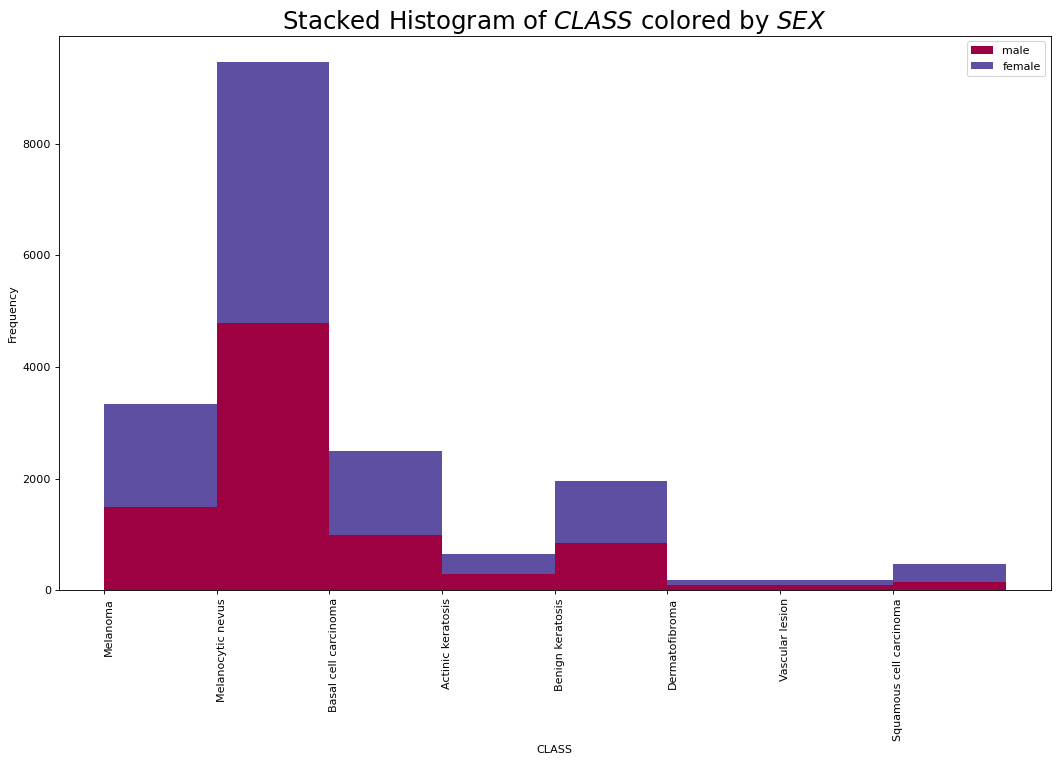

In [12]:
# Prepare data
x_var = "CLASS"
groupby_var = "SEX"
metadata_train_agg = metadata_train.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [
    metadata_train[x_var].values.tolist() for i, metadata_train in metadata_train_agg
]

# Draw
plt.figure(figsize=(16, 9), dpi=80)
colors = [plt.cm.Spectral(i / float(len(vals) - 1)) for i in range(len(vals))]
n, bins, patches = plt.hist(
    vals,
    bins=metadata_train[x_var].unique().__len__(),
    stacked=True,
    density=False,
    color=colors[: len(vals)],
)

# Decoration
plt.legend(
    {
        group: col
        for group, col in zip(
            metadata_train[groupby_var].unique().tolist(), colors[: len(vals)]
        )
    }
)
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.xticks(
    ticks=bins[:-1],
    labels=CLASS_LABELS.values(),
    rotation=90,
    horizontalalignment="left",
)
plt.show()

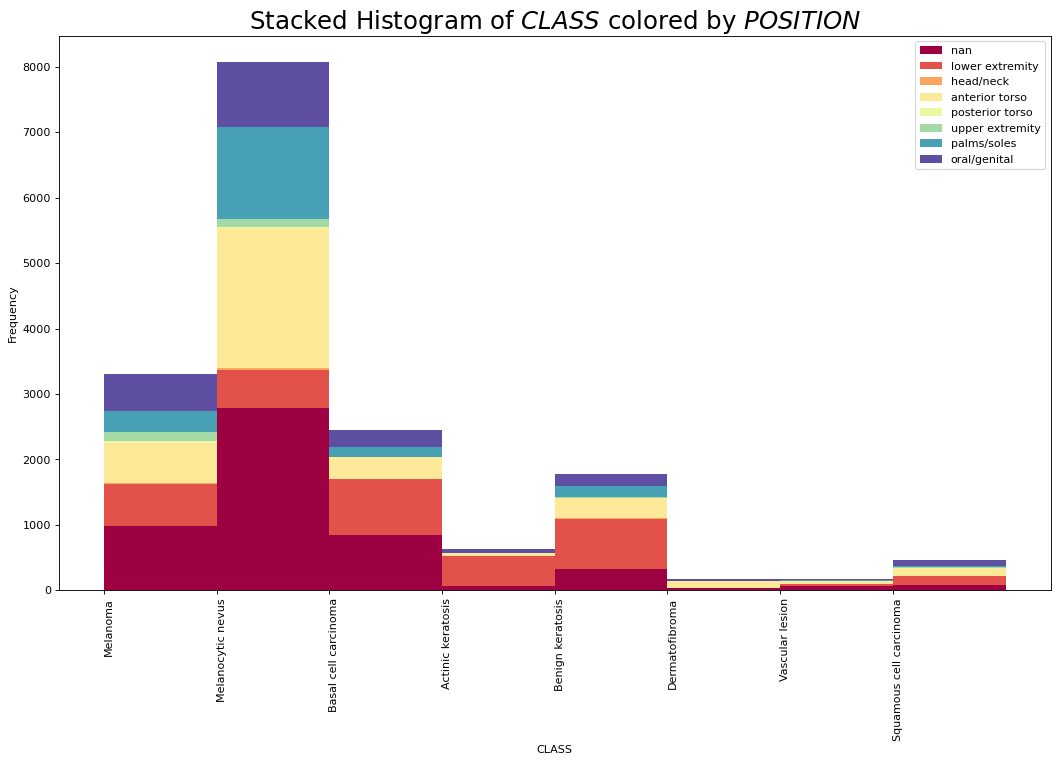

In [13]:
# Prepare data
x_var = "CLASS"
groupby_var = "POSITION"
metadata_train_agg = metadata_train.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [
    metadata_train[x_var].values.tolist() for i, metadata_train in metadata_train_agg
]

# Draw
plt.figure(figsize=(16, 9), dpi=80)
colors = [plt.cm.Spectral(i / float(len(vals) - 1)) for i in range(len(vals))]
n, bins, patches = plt.hist(
    vals,
    bins=metadata_train[x_var].unique().__len__(),
    stacked=True,
    density=False,
    color=colors[: len(vals)],
)

# Decoration
plt.legend(
    {
        group: col
        for group, col in zip(
            metadata_train[groupby_var].unique().tolist(), colors[: len(vals)]
        )
    }
)
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.xticks(
    ticks=bins[:-1],
    labels=CLASS_LABELS.values(),
    rotation=90,
    horizontalalignment="left",
)
plt.show()

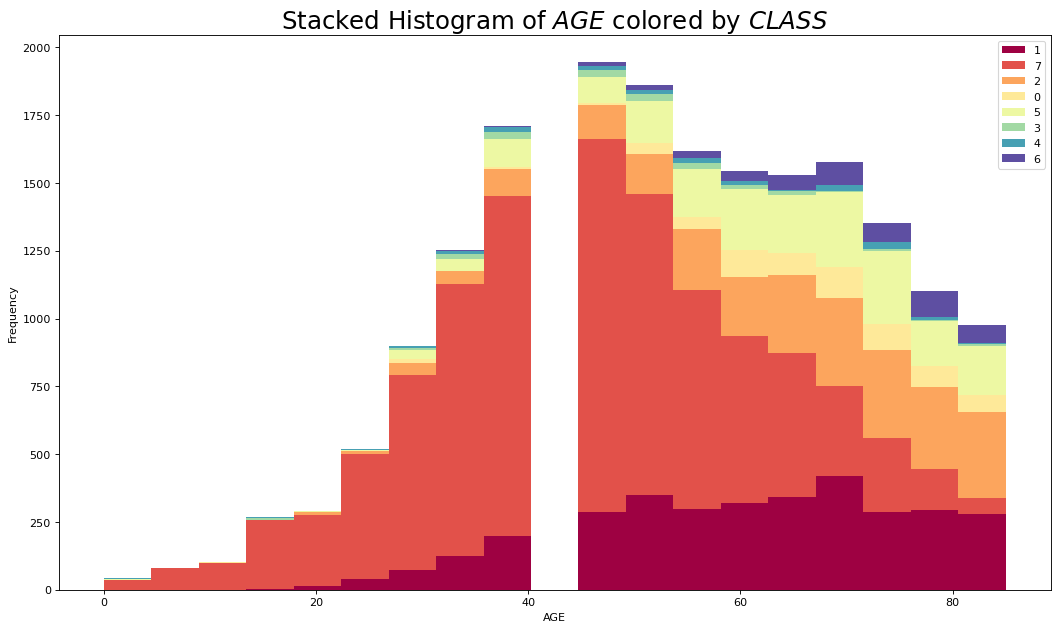

In [14]:
# Prepare data
x_var = "AGE"
groupby_var = "CLASS"
metadata_train_agg = metadata_train.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [
    metadata_train[x_var].values.tolist() for i, metadata_train in metadata_train_agg
]

# Draw
plt.figure(figsize=(16, 9), dpi=80)
colors = [plt.cm.Spectral(i / float(len(vals) - 1)) for i in range(len(vals))]
n, bins, patches = plt.hist(
    vals,
    bins=metadata_train[x_var].unique().__len__(),
    stacked=True,
    density=False,
    color=colors[: len(vals)],
)

# Decoration
plt.legend(
    {
        group: col
        for group, col in zip(
            metadata_train[groupby_var].unique().tolist(), colors[: len(vals)]
        )
    }
)
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.show()

Based on the preliminary data analysis, it's evident that there's a significant class imbalance. This issue must be addressed appropriately; otherwise, the models may tend to overfit, primarily focusing on predicting the class *Melanocytic nevus*, which has a considerably higher frequency compared to other classes.

Even after further visualizations, which were excluded from this report for readability, we have not discerned a clear correlation between the sex, position, and age data in the image metadata and their respective diagnostic cases. Consequently, we have opted for a classification strategy utilizing alternative features: ABCD features and bi-dimensional features. In both methodologies, accurately segmenting the lesion area with masks is imperative for optimal feature extraction or to direct the model towards the region of interest. Therefore, we employ a U-Net inspired architecture for the lesion segmentation process.

## Segmentation: U-Net

In this section, the U-Net [1] architecture is employed for segmentation tasks within our study.

The U-Net architecture, revolutionized medical image segmentation by providing a robust framework for precise pixel-wise classification. It employs a symmetric encoder-decoder design, comprising a contracting path for feature extraction and an expansive path for segmentation. U-Net's innovative approach addresses challenges like limited data and class imbalance in medical imaging, making it a cornerstone in automated medical image analysis.

U-Net's encoder-decoder structure involves a contracting path with convolutional and pooling layers for feature extraction and a corresponding expansive path using transposed convolutions for segmentation. Skip connections bridge encoding and decoding layers, preserving spatial information and mitigating information loss during downsampling. This integration of low-level details with high-level semantics enhances localization accuracy, while tailored loss functions and data augmentation techniques further optimize performance and generalization.

U-Net's significance in medical image segmentation is profound, offering great accuracy and efficiency in delineating anatomical structures and pathological regions. By effectively addressing challenges like class imbalance and information loss, U-Net empowers clinicians and researchers with precise tools for medical diagnosis, treatment planning, and disease monitoring.

### Hyperparameters

In the subsequent cell, we outline the hyperparameters utilized for the U-Net segmentation model.

Specifically, we opted to leverage only the HS channels while disregarding the V component. This deliberate choice was made to exclude illumination conditions from influencing the segmentation process.

After extracting the mask using the U-Net model, a series of post-processing steps are applied. These include the application of a Gaussian filter to mitigate noise, thresholding the resultant image to generate a binary mask, dilation to address model inaccuracies and create denser masks, and ultimately, the removal of small objects and holes to refine the segmentation output. Through this systematic approach, we aim to enhance the accuracy and reliability of our segmentation results.

In [ ]:
NUM_C_CHANNELS = 2
C_SPACE = "HSV"

VAL_SPLIT = 0.25

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_EPOCHS = 100

GAUSSIAN_KERNEL = 5
GAUSSIAN_SIGMA = 2
MASK_THRESHOLD = 0.5
DISK_SIZE = 10
MIN_OBJECT_SIZE = 40

### Model definition

To deploy our `UNet` architecture effectively, we utilize the `Encoder` and `Decoder` classes. These classes leverage bi-dimensional Convolutional Neural Network blocks (`Block`) to construct the architecture. By modularizing our approach in this manner, we enhance code readability, maintainability, and scalability, ensuring efficient implementation of the U-Net model for our segmentation tasks.

In [ ]:
class Block(Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = Conv2d(in_channels, out_channels, (3, 3))
        self.relu = ReLU()
        self.conv2 = Conv2d(out_channels, out_channels, (3, 3))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        output = self.conv2(x)
        return output

In [ ]:
class Encoder(Module):
    def __init__(self, channels=(NUM_C_CHANNELS, 16, 32, 64)):
        super().__init__()

        self.encoding_blocks = ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = MaxPool2d((2, 2))

    def forward(self, x):
        block_outputs = []

        for block in self.encoding_blocks:
            x = block(x)
            block_outputs.append(x)
            x = self.pool(x)

        return block_outputs

In [ ]:
class Decoder(Module):
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()

        self.channels = channels
        self.up_convolutions = ModuleList(
            [
                ConvTranspose2d(channels[i], channels[i + 1], (2, 2), 2)
                for i in range(len(channels) - 1)
            ]
        )
        self.decoding_blocks = ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )

    def forward(self, x, encoding_features):
        for i in range(len(self.channels) - 1):
            x = self.up_convolutions[i](x)
            encoding_feature = self.crop(encoding_features[i], x)
            x = torch.cat([x, encoding_feature], dim=1)
            x = self.decoding_blocks[i](x)
        return x

    def crop(self, encoding_features, x):
        (_, _, H, W) = x.shape
        encoding_features = v2.functional.center_crop(encoding_features, [H, W])
        return encoding_features

In [ ]:
class UNet(Module):
    def __init__(
        self,
        encoding_channels=(3, 16, 32, 64),
        decoding_channels=(64, 32, 16),
        num_classes=1,
        retain_dim=True,
        out_size=(128, 128),
    ):
        super().__init__()
        self.encoder = Encoder(encoding_channels)
        self.decoder = Decoder(decoding_channels)
        self.head = Conv2d(decoding_channels[-1], num_classes, (1, 1))
        self.retain_dim = retain_dim
        self.out_size = out_size

    def forward(self, x):
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(
            encoding_features[::-1][0], encoding_features[::-1][1:]
        )
        output = self.head(decoding_features)
        if self.retain_dim:
            output = interpolate(output, self.out_size)
        return output

### Dataset definition

To comprehensively train and validate our U-Net model, we utilize all available masks from both the `Train` and `Test` directories. To enhance the robustness of our results and mitigate overfitting, we apply various transformations, such as resizing, random cropping, random flipping, random rotation, and normalization. This augmentation strategy diversifies the dataset, enabling our model to generalize effectively to unseen data while minimizing overfitting risks.

Moreover, by leveraging `torch`, we efficiently read images in batches, reducing the computational overhead associated with dataset consolidation. This batch processing capability optimizes computational resources, facilitating smoother training and validation processes for our U-Net model.

In [ ]:
class CNNSegmentationDataset(Dataset):
    """
    Dataset class for loading images and segmentation masks for CNN-based segmentation tasks.

    Args:
        root (str): Root directory containing images and masks.
        metadata (DataFrame): Metadata containing image IDs and corresponding labels.
        train (bool): Whether the dataset is for training or not.
        num_c_channels (int, optional): Number of channels in the images. Default is 3.
        c_space (str, optional): Color space to convert the images to. Default is "RGB".
        transforms (list of ``torchvision.transforms.Transform`` objects, optional):
            Optional transforms to be applied to the images.
    """

    def __init__(
        self,
        root,
        metadata,
        train,
        num_c_channels=3,
        c_space="RGB",
        transforms=None,
    ):
        self.root = root
        self.metadata = metadata
        self.train = train
        self.num_c_channels = num_c_channels
        self.c_space = c_space

        if transforms:
            self.transforms = v2.Compose(transforms)
        else:
            self.transforms = None

        self.images_with_mask_filename = [
            filename[:-8]
            for filename in os.listdir(self.root)
            if filename.endswith("_seg.png")
        ]
        self.images_without_mask_filename = [
            image_filename
            for image_filename in metadata["ID"]
            if image_filename not in self.images_with_mask_filename
        ]

        self.pre_transforms = v2.Compose(
            [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
        )
        self.image_post_transforms = v2.Compose(
            [v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
        )

    def __len__(self):
        if self.train:
            return len(self.images_with_mask_filename)
        return len(self.images_without_mask_filename)

    def __getitem__(self, index):
        if self.train:
            image_filename = self.images_with_mask_filename[index]

            mask_filename = image_filename + "_seg"
            mask_path = os.path.join(self.root, mask_filename + ".png")
            mask = Image.open(mask_path, formats=["PNG"]).convert("L")
            mask = Mask(self.pre_transforms(mask))

            image_path = os.path.join(self.root, image_filename + ".jpg")
            image = Image.open(image_path, formats=["JPEG"]).convert(self.c_space)
            image = self.pre_transforms(image)

            if self.transforms:
                image, mask = self.transforms(image, mask)
        else:
            image_filename = self.images_without_mask_filename[index]
            image_path = os.path.join(self.root, image_filename + ".jpg")
            image = Image.open(image_path, formats=["JPEG"]).convert(self.c_space)
            image = self.pre_transforms(image)
            image = self.transforms(image)

        image = self.image_post_transforms(image)
        image = image[: self.num_c_channels]

        if self.train:
            return image, mask
        return image

### Train-validation model

#### Data import

In [ ]:
metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_test = pd.read_csv(os.path.join(DATA_PATH, "metadataTest.csv"))

transforms = [
    v2.Resize((140, 140)),
    v2.RandomCrop((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=180),
]

In [ ]:
train_data1 = CNNSegmentationDataset(
    root=TRAIN_DATA_PATH,
    metadata=metadata_train,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

train_data2 = CNNSegmentationDataset(
    root=TEST_DATA_PATH,
    metadata=metadata_test,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

train_data = ConcatDataset([train_data1, train_data2])

Once all masks (targets) and their corresponding images (inputs) from both the `Train` and `Test` directories have been read, we proceed to split the resulting dataset into two sets. One set is designated for training the U-Net model, while the other is reserved for validating the model's performance and generalization capabilities on the training set. It's crucial to note that, at this stage, images without an available mask are disregarded from consideration. This selective approach ensures the integrity of the training and validation datasets, facilitating a focused evaluation of the model's effectiveness in segmentation tasks.

In [ ]:
print("[INFO] generating the train/validation split...")

train_indices, val_indices = train_test_split(
    range(len(train_data)),
    test_size=VAL_SPLIT,
    random_state=RANDOM_SEED,
)

val_data = Subset(train_data, val_indices)
train_data = Subset(train_data, train_indices)

In [ ]:
train_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)

val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

train_steps = len(train_data_loader.dataset) // BATCH_SIZE
val_steps = len(val_data_loader.dataset) // BATCH_SIZE

#### Data visualization

In [ ]:
data_iter = iter(train_data_loader)
images, masks = next(data_iter)

for channel in range(NUM_C_CHANNELS):
    fig, axs = plt.subplots(8, 2, figsize=(4, 16), dpi=80)

    fig.suptitle(f"Channel {channel}")
    for index in range(8):
        image = v2.functional.normalize(
            images[index],
            mean=[-0.5 / 0.5] * NUM_C_CHANNELS,
            std=[1 / 0.5] * NUM_C_CHANNELS,
        )[channel]
        mask = masks[index][0]
        axs[index, 0].imshow(image, cmap="gray")
        axs[index, 0].set_title("Image")
        axs[index, 0].axis("off")
        axs[index, 1].imshow(mask, cmap="gray")
        axs[index, 1].set_title("Mask")
        axs[index, 1].axis("off")

    plt.tight_layout()
    plt.show()

![Visualization UNet.png](<attachment:Visualization UNet.png>)
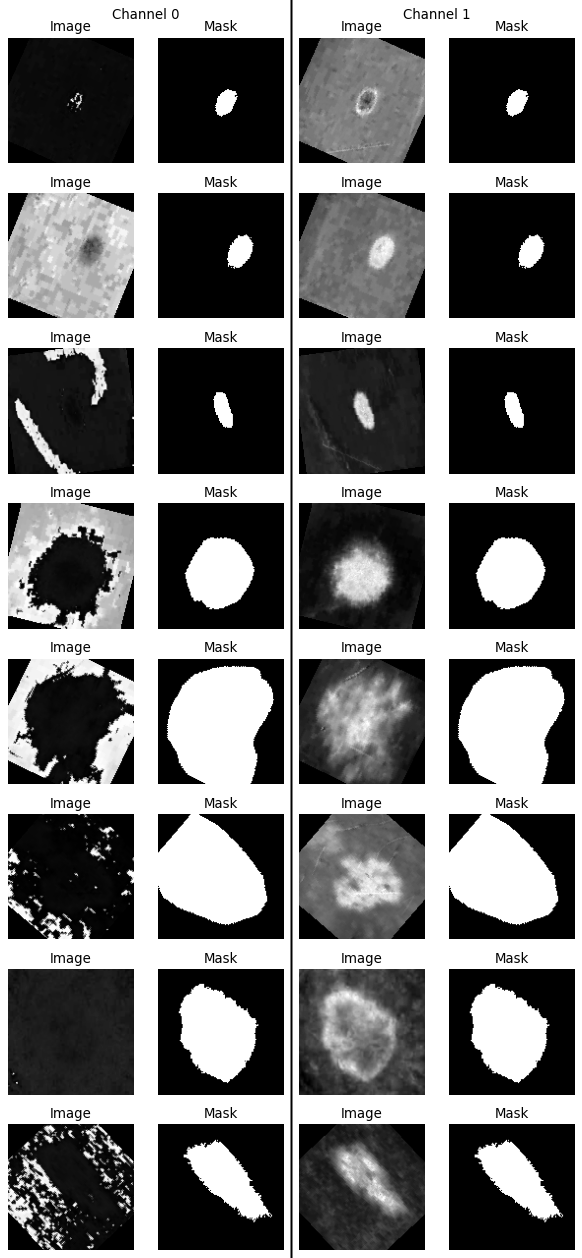

#### Model instantiation

The `Adam` optimizer and `BCEWithLogitsLoss` have been chosen as the optimization algorithm and loss function, respectively, with the parameter `reduction="sum"`, to address potential overfitting. This selection aims to achieve a balance between model optimization and regularization, thereby ensuring robust performance across the dataset.

In [ ]:
print("[INFO] initializing the U-Net model...")

model = model = UNet(
    encoding_channels=(NUM_C_CHANNELS, 16, 32, 64),
    decoding_channels=(64, 32, 16),
    num_classes=1,
    retain_dim=True,
    out_size=(128, 128),
).to(DEVICE)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = BCEWithLogitsLoss(reduction="sum")

H = {"train_loss": [], "val_loss": []}

#### Model training

In [ ]:
print("[INFO] training the network...")

for epoch in range(0, MAX_EPOCHS):
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    with tqdm(train_data_loader, unit="batch") as training_epoch:
        for x, y in training_epoch:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            pred = model(x)

            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss

    with torch.no_grad(), tqdm(val_data_loader, unit="batch") as val_epoch:
        model.eval()
        for x, y in val_epoch:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            pred = model(x)

            total_val_loss += loss_function(pred, y)

    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())

    print(f"[INFO] EPOCH: {epoch + 1}/{MAX_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.6f}, Val loss: {avg_val_loss:.6f}\n")

After thoroughly training the U-Net model to achieve an acceptable loss function value, a crucial step is employed to prevent overfitting: selecting the epoch with the lowest validation loss. This epoch serves as a metric indicating the optimal balance between model complexity and generalization. By identifying the epoch with the least validation loss, the parameters learned by the model generalize well to unseen data, enhancing its reliability and effectiveness in real-world applications.

In [ ]:
best_epoch = np.argmin(H["val_loss"]) + 1

#### Model evaluation

In [ ]:
print("[INFO] evaluating network...")

fig, ax = plt.subplots(figsize=(16, 10), dpi=80)

fig.suptitle("Train-validation model history", fontsize=24)
ax.set_ylabel("Loss", fontsize=22)
ax.plot(range(1, MAX_EPOCHS + 1), H["train_loss"], color="tab:blue", label="Train")
ax.plot(range(1, MAX_EPOCHS + 1), H["val_loss"], color="tab:orange", label="Test")

ax.axvline(x=best_epoch, linestyle="--", alpha=0.6, color="tab:red", label="Best epoch")
ax.grid(axis="both", alpha=0.3)
ax.spines[["top", "right"]].set_alpha(0.0)
ax.spines[["bottom", "left"]].set_alpha(0.3)
ax.legend()

plt.tight_layout()
plt.show()

![Train-validation UNet.png](<attachment:Train-validation UNet.png>)
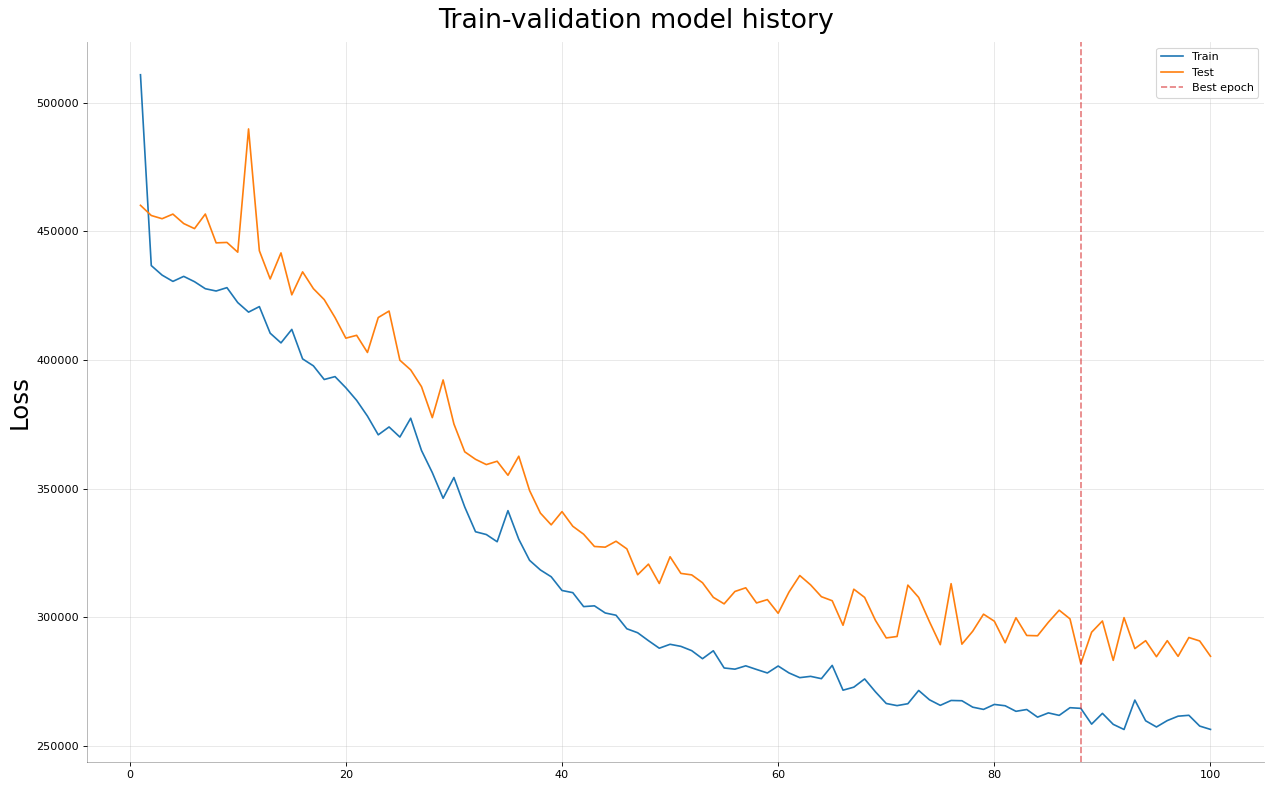

In the visualization provided, it is evident that the model does not exhibit signs of overfitting, as both the training loss and the validation loss consistently decrease with each epoch. This trend signifies that the model is effectively learning from the training data while also generalizing well to unseen validation data. Such behavior underscores the robustness and reliability of the model's performance across various datasets, instilling confidence in its ability to accurately classify and generalize beyond the training set.

In [ ]:
data_iter = iter(val_data_loader)
images, masks = next(data_iter)

In [ ]:
with torch.no_grad():
    model.eval()

    (images, masks) = (images.to(DEVICE), masks.to(DEVICE))
    pred = model(images)

    for auth_mask, mask in zip(pred[:8], masks[:8]):
        auth_mask = v2.functional.gaussian_blur(
            auth_mask, kernel_size=GAUSSIAN_KERNEL, sigma=GAUSSIAN_SIGMA
        )
        auth_mask = torch.sigmoid(auth_mask).cpu().numpy().squeeze(0)
        auth_mask = auth_mask > MASK_THRESHOLD
        auth_mask = binary_dilation(auth_mask, disk(DISK_SIZE))
        auth_mask = remove_small_holes(
            remove_small_objects(auth_mask, min_size=MIN_OBJECT_SIZE),
            area_threshold=MIN_OBJECT_SIZE,
        )
        auth_mask = (auth_mask * 255).astype(np.uint8)
        auth_mask = v2.functional.to_pil_image(auth_mask, mode="L")

        mask = v2.functional.to_pil_image(mask.squeeze(0), mode="L")

        fig, axs = plt.subplots(1, 2, figsize=(8, 8), dpi=80)

        axs[0].imshow(auth_mask, cmap="gray")
        axs[0].set_title("Authorial mask")
        axs[0].axis("off")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("True mask")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

![Train-validation UNet - im.png](<attachment:Train-validation UNet - im.png>)
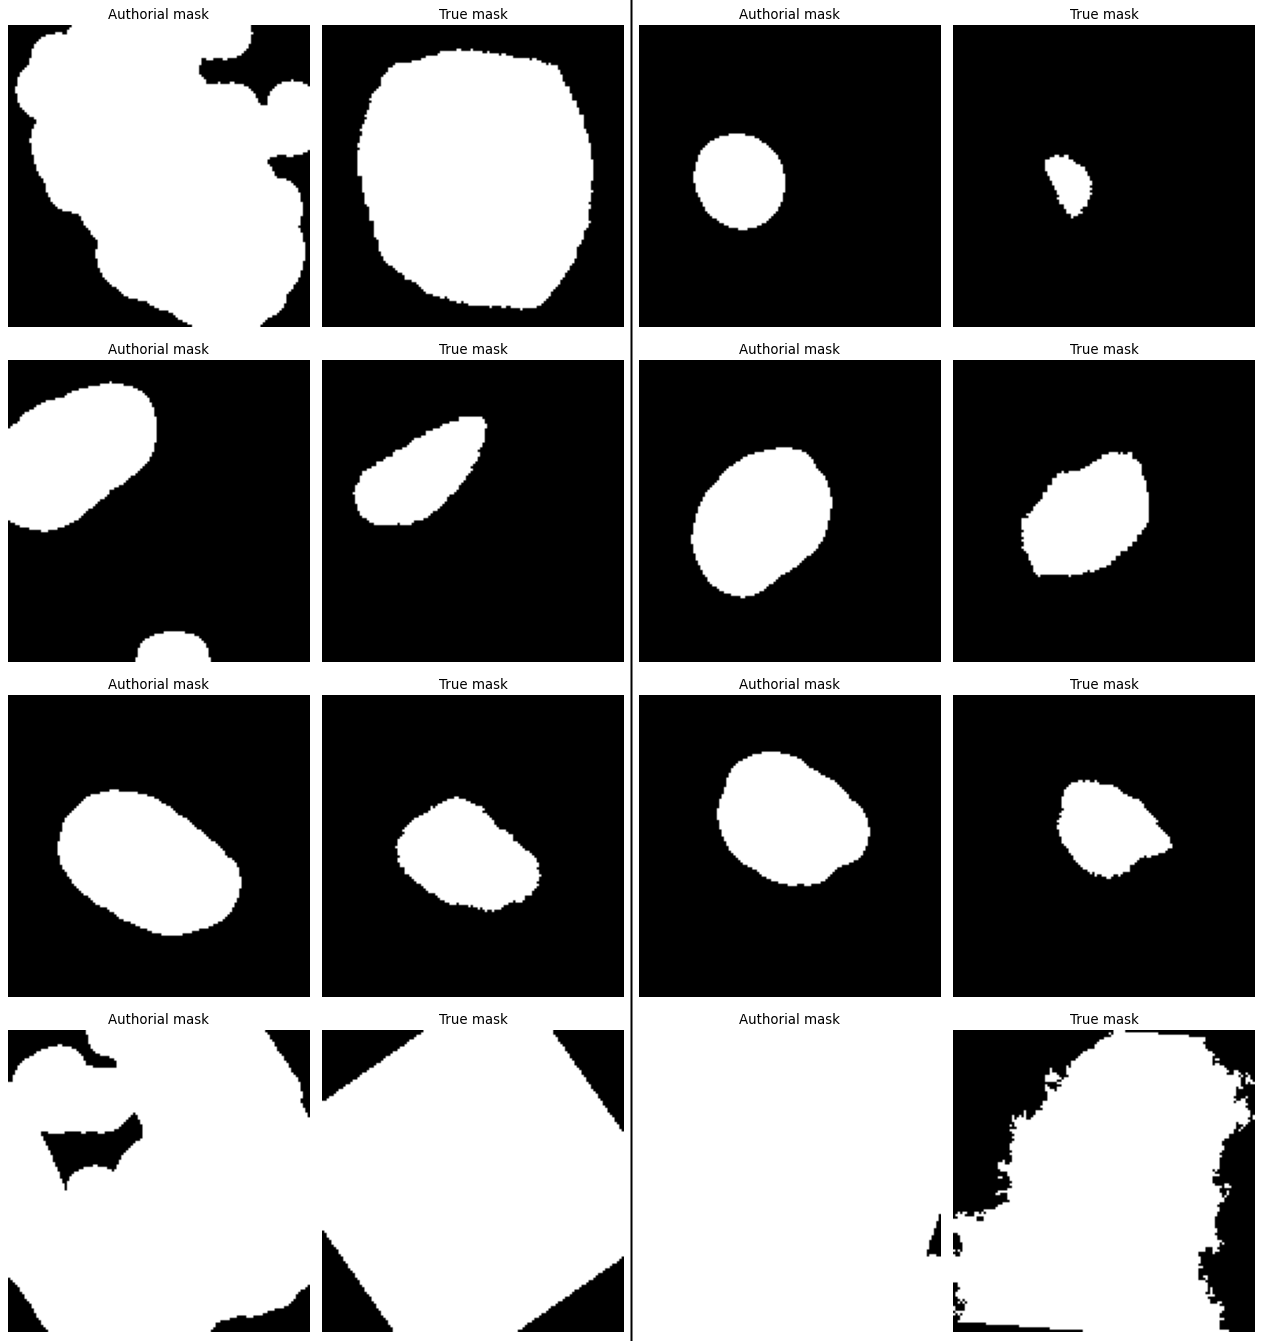

In the visualization provided, it is noticeable that the model tends to segment localized lesions more effectively compared to sparse lesions. This observation suggests that implementing spatial normalization of the lesions, such as centering and resizing them to an average position, could be a beneficial preprocessing step for enhancing the model's performance. However, despite this discrepancy, it is worth noting that the model still generates acceptable segmentation masks overall. This underscores its capability to delineate pathological regions, albeit with room for improvement through preprocessing techniques like spatial normalization.

The selected hyperparameters have demonstrated their efficacy for the U-Net model, resulting in a significant reduction in the chosen loss function. With this validation, confidence is gained in proceeding to train the model on the entire training-validation set using the same hyperparameters. This comprehensive training approach will facilitate the creation of masks for the test set, ensuring a thorough evaluation of the model's performance across the entire dataset.

### Train-test model

During this phase, the same transformations and hyperparameters used for the training-validation set are applied to process the images previously lacking masks. This uniform approach ensures consistency and comparability in the segmentation pipeline. Leveraging the trained U-Net model, the lesions within these images are segmented, generating masks (predictions) that can be utilized for various purposes. These masks serve as invaluable resources for feature extraction or as supplementary inputs for subsequent classification models. Through this iterative process, the utility of the segmentation model is maximized, enabling comprehensive analysis and extraction of insights from the entire dataset.

#### Data import

In [ ]:
metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_test = pd.read_csv(os.path.join(DATA_PATH, "metadataTest.csv"))

transforms = [
    v2.Resize((140, 140)),
    v2.RandomCrop((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=180),
]

In [ ]:
train_data1 = CNNSegmentationDataset(
    root=TRAIN_DATA_PATH,
    metadata=metadata_train,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

train_data2 = CNNSegmentationDataset(
    root=TEST_DATA_PATH,
    metadata=metadata_test,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

train_data = ConcatDataset([train_data1, train_data2])

test_data1 = CNNSegmentationDataset(
    root=TRAIN_DATA_PATH,
    metadata=metadata_train,
    train=False,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

test_data2 = CNNSegmentationDataset(
    root=TEST_DATA_PATH,
    metadata=metadata_test,
    train=False,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    transforms=transforms,
)

In [ ]:
train_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)

train_steps = len(train_data_loader.dataset) // BATCH_SIZE

test_data_loader1 = DataLoader(test_data1, batch_size=BATCH_SIZE)
test_data_loader2 = DataLoader(test_data2, batch_size=BATCH_SIZE)

#### Model instantiation

In [ ]:
print("[INFO] initializing the U-Net model...")

model = model = UNet(
    encoding_channels=(NUM_C_CHANNELS, 16, 32, 64),
    decoding_channels=(64, 32, 16),
    num_classes=1,
    retain_dim=True,
    out_size=(128, 128),
).to(DEVICE)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = BCEWithLogitsLoss(reduction="sum")

H = {"train_loss": []}

#### Model training

In [ ]:
print("[INFO] training the network...")

for epoch in range(0, best_epoch):
    model.train()

    total_train_loss = 0

    with tqdm(train_data_loader, unit="batch") as training_epoch:
        for x, y in training_epoch:
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            pred = model(x)

            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss

    avg_train_loss = total_train_loss / train_steps

    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())

    print(f"[INFO] EPOCH: {epoch + 1}/{MAX_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.6f}\n")

#### Model evaluation

In [ ]:
print("[INFO] evaluating network...")

fig, ax = plt.subplots(figsize=(16, 10), dpi=80)

fig.suptitle("Train-test model history", fontsize=24)
ax.set_ylabel("Loss", fontsize=22)
ax.plot(range(1, best_epoch + 1), H["train_loss"], color="tab:blue", label="Train")

ax.axvline(x=best_epoch, linestyle="--", alpha=0.6, color="tab:red", label="Best epoch")
ax.grid(axis="both", alpha=0.3)
ax.spines[["top", "right"]].set_alpha(0.0)
ax.spines[["bottom", "left"]].set_alpha(0.3)
ax.legend()

plt.tight_layout()
plt.show()

![Train-test UNet.png](<attachment:Train-test UNet.png>)
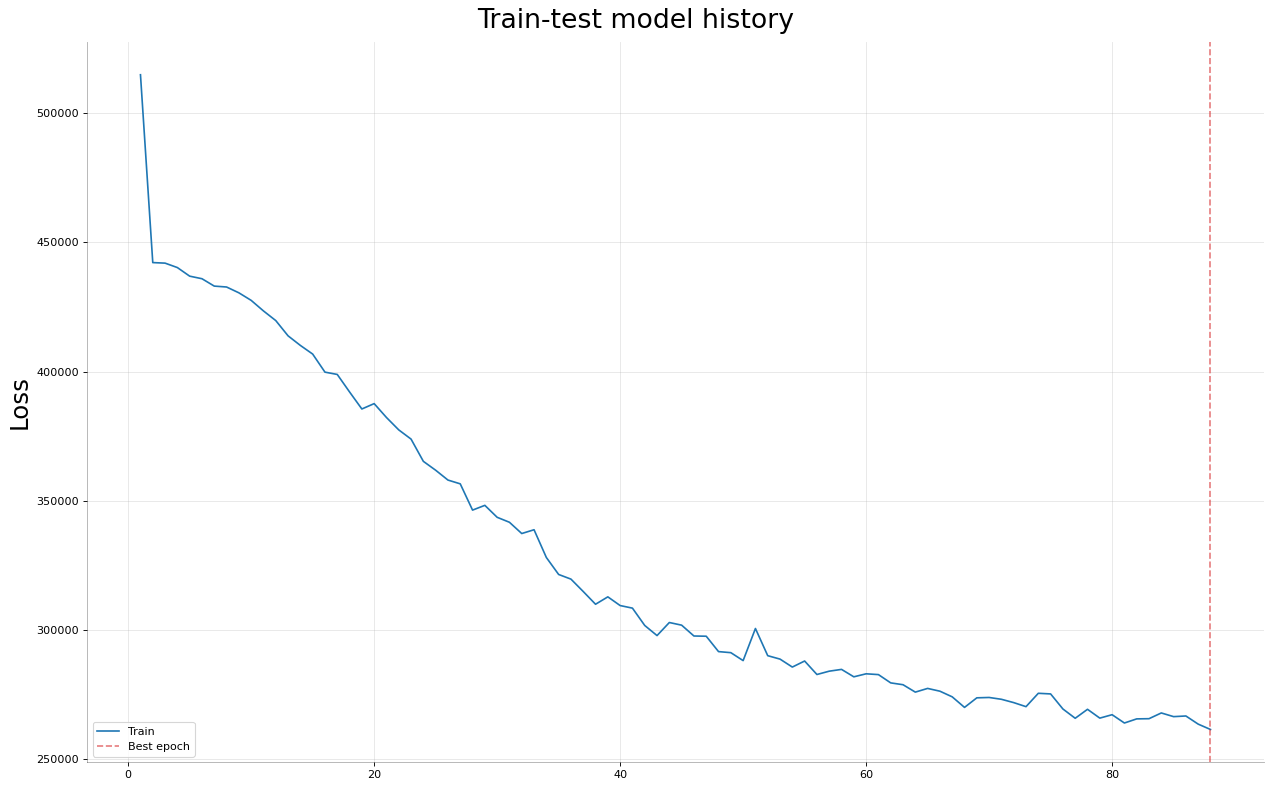

#### Model persistence

Once the U-Net model, trained on the training-validation set, has successfully segmented lesions, post-processing steps are implemented to enhance the stability of the masks. Initially, a Gaussian filter is applied to alleviate noise present in the segmented masks. Subsequently, a threshold is applied to the image to effectively delineate lesion regions. Following this, dilation operations are performed to refine the mask boundaries and ensure comprehensive coverage of lesion areas. Finally, a process is conducted to remove small objects and fill any holes within the segmented regions. These post-processing techniques collectively contribute to stabilizing the segmentation results, thereby improving the accuracy and reliability of lesion delineation.

In [ ]:
def post_process_mask(mask):
    """
    Apply post-processing steps to refine a mask.

    Args:
        mask (torch.Tensor): Input tensor representing the mask.

    Returns:
        PIL.Image: Processed mask after applying post-processing steps.

    Notes:
        This function applies a series of post-processing steps to refine the input mask.
        The steps include Gaussian blurring, sigmoid transformation, thresholding, binary dilation,
        and removal of small holes and objects.

        Ensure that the input mask tensor has the shape (1, H, W), where H and W represent
        the height and width of the mask respectively.
    """
    mask = v2.functional.gaussian_blur(
        mask, kernel_size=GAUSSIAN_KERNEL, sigma=GAUSSIAN_SIGMA
    )
    mask = torch.sigmoid(mask).cpu().numpy().squeeze(0)
    mask = mask > MASK_THRESHOLD
    mask = binary_dilation(mask, disk(DISK_SIZE))
    mask = remove_small_holes(
        remove_small_objects(mask, min_size=MIN_OBJECT_SIZE),
        area_threshold=MIN_OBJECT_SIZE,
    )
    mask = (mask * 255).astype(np.uint8)
    mask = v2.functional.to_pil_image(mask, mode="L")

    return mask

In [ ]:
auth_mask_path = os.path.join(TRAIN_DATA_PATH, "auth")

if not os.path.exists(auth_mask_path):
    os.mkdir(auth_mask_path)

index = 0
with torch.no_grad(), tqdm(test_data_loader1, unit="batch") as test_epoch:
    model.eval()

    for x in test_epoch:
        x = x.to(DEVICE)
        pred = model(x)

        for auth_mask in pred:
            auth_mask = post_process_mask(auth_mask)

            auth_mask.save(
                os.path.join(
                    auth_mask_path,
                    test_data1.images_without_mask_filename[index] + "_seg.png",
                )
            )
            index += 1

In [ ]:
auth_mask_path = os.path.join(TEST_DATA_PATH, "auth")

if not os.path.exists(auth_mask_path):
    os.mkdir(auth_mask_path)

index = 0
with torch.no_grad(), tqdm(test_data_loader2, unit="batch") as test_epoch:
    model.eval()

    for x in test_epoch:
        x = x.to(DEVICE)
        pred = model(x)

        for auth_mask in pred:
            auth_mask = post_process_mask(auth_mask)

            auth_mask.save(
                os.path.join(
                    auth_mask_path,
                    test_data2.images_without_mask_filename[index] + "_seg.png",
                )
            )
            index += 1

In [ ]:
torch.save(model, "UNet.pt")

## ABCD features

The ABCD rule serves as a mnemonic guide in dermatology for identifying potential signs of melanoma, a serious form of skin cancer. Each letter represents a crucial characteristic to evaluate when examining moles or skin lesions. A stands for asymmetry, indicating whether one half of the lesion differs from the other in shape or size. B refers to border irregularity, assessing the edges of the lesion for jaggedness or unevenness. C denotes color variation within the lesion, observing for multiple colors or shades present. Lastly, D represents diameter, evaluating the size of the lesion. In this academic endeavor, we meticulously consider the ABCD features as delineated in reference [2].

These essential traits can be derived from the masks produced by the lesion segmentation conducted by the U-Net model. Through scrutinizing the segmented lesions, we evaluate asymmetry, border irregularity, color variation, and diameter, facilitating the early identification and diagnosis of potential melanomas. This utilization exemplifies the role of sophisticated image analysis methods in dermatological diagnostics and patient care.

Although the current implementation aims for readability by resembling a mathematical formula, it lacks computational efficiency.

### Hyperparameters

In this specific section, we leverage all three channels within the RGB space. We extract the ABCD features while maintaining consistency in size with the masks generated by our U-Net model.

In [ ]:
NUM_C_CHANNELS = 3

BATCH_SIZE = 64

MASK_SHAPE = (128, 128)

### Dataset definition

The custom dataset designed for this section retrieves each image and its corresponding mask pair. Since this section follows the execution of the U-Net segmentation step, we can assume that every image already has its associated segmentation mask available.

In [ ]:
class MaskDataset(Dataset):
    """
    Dataset class for loading segmentation masks.

    Args:
        root (str): Root directory containing masks.
        metadata (DataFrame): Metadata containing image IDs and corresponding labels.
        num_c_channels (int, optional): Number of channels in the images. Default is 3.
        mask_shape (tuple, optional):
            Mask shape to resize read images to. Default is (128, 128).
    """

    def __init__(self, root, num_c_channels=3, mask_shape=(128, 128)):
        self.root = root
        self.num_c_channels = num_c_channels
        self.mask_shape = mask_shape

        self.masks_path = [
            os.path.join(self.root, filename)
            for filename in os.listdir(self.root)
            if filename.endswith("_seg.png")
        ] + [
            os.path.join(self.root, "auth", filename)
            for filename in os.listdir(os.path.join(self.root, "auth"))
            if filename.endswith("_seg.png")
        ]

        self.mask_transforms = v2.Compose([v2.Resize(mask_shape)])
        self.image_transforms = v2.Compose(
            [v2.ToImage(), v2.Resize(mask_shape), v2.ToDtype(torch.float32, scale=True)]
        )
        self.basenames = [os.path.basename(masks_path[:-8]) for masks_path in self.masks_path]

    def __len__(self):
        return len(self.masks_path)

    def __getitem__(self, index):
        mask_path = self.masks_path[index]
        image_path = os.path.join(
            self.root, self.basenames[index] + ".jpg"
        )

        mask = np.array(Image.open(mask_path, formats=["PNG"]).convert("L"))
        image = np.array(Image.open(image_path, formats=["JPEG"]).convert("RGB"))

        # Spatially normalize masks with a non-zero bounding box
        non_zero = np.nonzero(mask)
        if np.any(non_zero):
            min_row = np.min(non_zero[0])
            max_row = np.max(non_zero[0])
            min_col = np.min(non_zero[1])
            max_col = np.max(non_zero[1])

            mask = mask[min_row : max_row + 1, min_col : max_col + 1, np.newaxis]
            image = image[min_row : max_row + 1, min_col : max_col + 1, :]

            # Pad the mask so resize does not affect symmetry
            pad_length = (np.max(mask.shape[:-1]) - np.min(mask.shape[:-1])) // 2
            if np.argmax(mask.shape) == 0:
                pad_tuple = (pad_length, pad_length, 0, 0, 0, 0)
            elif np.argmax(mask.shape) == 1:
                pad_tuple = (0, 0, pad_length, pad_length, 0, 0)
            mask = pad(v2.functional.to_image(mask), pad=pad_tuple)
            image = pad(v2.functional.to_image(image), pad=pad_tuple)
        else:
            mask = torch.ones((1, *self.mask_shape))

        mask = v2.functional.to_dtype(mask, torch.bool)

        mask = self.mask_transforms(mask)
        image = self.image_transforms(image)

        masked_image = image * mask

        return mask, masked_image

### A features

As part of feature A, we calculate the asymmetry index using the formula: $\text{IS} = \frac{A \cap B}{A \cup B}$.

In [ ]:
def assymetry_index(mask):
    """
    Calculate the asymmetry index of a binary mask.

    Parameters:
    - mask: Binary mask representing the lesion or object of interest.

    Returns:
    - float: The minimum asymmetry index among rotations by 90, 180, and 270 degrees.

    Notes:
    - As a simplification hypothesis, this function considers the principal axis of the mask to be vertical or horizontal,
        and the "center" of the mask as the center of the tensor.
    - The asymmetry index is calculated as the ratio of the intersection area to the union area between the original mask
        and its rotation by 90, 180, and 270 degrees. The minimum asymmetry index among these rotations is returned.
    """
    mask = v2.functional.to_dtype(mask, torch.uint8, scale=False)
    mask_np = mask.numpy()
    asymmetry_indexes = []
    for angle in [90, 180, 270]:
        rotated = v2.functional.to_dtype(
            v2.functional.rotate(mask, angle), torch.uint8, scale=False
        ).numpy()
        intersection = np.sum(np.bitwise_and(rotated, mask_np))
        union = np.sum(np.bitwise_or(rotated, mask_np))
        asymmetry_indexes.append(intersection / union)

    return np.min(asymmetry_indexes)

### B features

For B features, we calculate:

- Compactness: $C = \frac{P^2}{4\pi a}$, where $p$ and $a$ denote the perimeter and area of the lesion, respectively.
- Fractal dimension (D): $\log(N(r)) = D \times \log(r) + C_{ste}$, where $N(r)$ is the number of boxes contained within the borders of the mask
- Radial variance: $\text{Ed} = \frac{\frac{1}{P_L}\sum P \in C(d(p, G) m)^2}{m^2}$, where $m$ represents the average distance $d$ between the boundary points and the centroid $G$.

In [ ]:
def compactness(countour):
    """
    Calculate the compactness of a contour.

    Parameters:
        contour (ndarray): as extracted from cv2.findContours.
    """
    perimeter = cv2.arcLength(contour, closed=True)
    area = cv2.contourArea(contour)
    compactness = (perimeter ** 2) / (4 * np.pi * area)

    return compactness

In [ ]:
def count_boxes(mask, box_size):
    """
    Count the number of boxes containing non-zero pixels in a binary mask.

    Parameters:
        mask (ndarray): Binary mask represented as a numpy array.
        box_size (int): Size of the boxes used for counting.
    """
    count = 0
    rows, cols = mask.shape
    for i in range(0, rows, box_size):
        for j in range(0, cols, box_size):
            if np.any(mask[i : i + box_size, j : j + box_size]):
                count += 1
    return count


def fractal_dimension(mask):
    """
    Calculate the fractal dimension of a binary mask using box counting method.

    Parameters:
        mask (torch.Tensor): Binary mask tensor.
    """
    mask = mask.squeeze(0).numpy()

    box_sizes = 2 ** np.arange(1, int(np.log2(min(mask.shape))) - 1)
    counts = np.array([count_boxes(mask, box_size) for box_size in box_sizes])

    slope = linregress(np.log(counts), np.log(box_sizes))[0]

    fractal_dim = -slope

    return fractal_dim

In [ ]:
def center(mask):
    """
    Calculate the center of mass of a binary mask.

    Parameters:
        mask (torch.Tensor): Binary mask tensor.
    """
    mask = v2.functional.to_dtype(mask.squeeze(0), torch.uint8, scale=False).numpy()
    M = cv2.moments(mask)
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    return center

def radial_variance(center, contour):
    """
    Calculate the radial variance of a contour with respect to its center.

    Parameters:
        center (tuple): Coordinates of the center point (x, y).
        contour (ndarray): Contour represented as a numpy array.
    """
    radii = [np.linalg.norm(point[0] - center) for point in contour]
    return np.var(radii)

### C features

For C features we calculate, color channel:
- Correlation: $\text{Cor}=\sum\limits_i\sum\limits_j\frac{(i-\mu_x)(j-\mu_y)}{\sigma_x\sigma_y}p(i, j)$
- Homogeneity: $\text{CH}=\sum\limits_i\sum\limits_j\frac{p(i, j)}{1+|i, j|}$
- Energy: $E_n=\sum\limits_i\sum\limits_j(p(i, j))^2$
- Contrast: $\text{Contr}=\sum\limits_i\sum\limits_j(i-j)^2p(i, j)$

In [ ]:
def correlation(image):
    """
    Calculate the correlation coefficients for each channel of an image.

    Parameters:
        image (torch.Tensor): Input image tensor.
    """
    image = image.numpy()

    correlations = []
    for c_channel in image:
        p_i = np.sum(c_channel, axis=0)
        (mu_i, sigma_i) = (np.mean(p_i), np.std(p_i))
        p_j = np.sum(c_channel, axis=1)
        (mu_j, sigma_j) = (np.mean(p_j),np.std(p_j))
        correlation = 0
        for i in range(image.shape[1]):
            for j in range(image.shape[2]):
                correlation += c_channel[i, j]*(i - mu_i)*(j - mu_j)/(sigma_i*sigma_j)
        correlations.append(correlation)

    return correlations

In [ ]:
def homogeneity(image):
    """
    Calculate the homogeneity coefficients for each channel of an image.

    Parameters:
        image (torch.Tensor): Input image tensor.
    """
    image = image.numpy()
    homogeneities = []
    for c_channel in image:
        homogeneity = 0
        for i in range(image.shape[1]):
            for j in range(image.shape[2]):
                homogeneity += c_channel[i, j] / (1 + abs(i - j))
        homogeneities.append(homogeneity)
    return homogeneities

In [ ]:
def energy(image):
    """
    Calculate the energy coefficients for each channel of an image.

    Parameters:
        image (torch.Tensor): Input image tensor.
    """
    image = image.numpy()
    energy = np.sum(image ** 2, axis=(1, 2))
    return energy

In [ ]:
def contrast(image):
    """
    Calculate the contrast coefficients for each channel of an image.

    Parameters:
        image (torch.Tensor): Input image tensor.
    """
    image = image.numpy()
    contrasts = []
    for c_channel in image:
        contrast = 0
        for i in range(image.shape[1]):
            for j in range(image.shape[2]):
                contrast += ((i - j) ** 2) * c_channel[i, j]
        contrasts.append(contrast)
    return contrasts

### D features

For D features, we compute the diameter as the maximum distance between two points on the contour of the mask.

In [ ]:
def diameter(contour):
    """
    Calculate the maximum diameter of a contour.

    Parameters:
        contour (ndarray): as extracted from cv2.findContours.
    """
    max_diameter = 0

    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            distance = np.linalg.norm(contour[i] - contour[j])
            if distance > max_diameter:
                max_diameter = distance

    return max_diameter

### Data import

Once the functions for calculating the ABCD features are defined, the next step is to read the masks using the `MaskDataset`, as previously defined. This dataset provides a convenient interface for accessing and working the image masks, in batches

In [ ]:
train_data = MaskDataset(
    root=TRAIN_DATA_PATH, num_c_channels=NUM_C_CHANNELS, mask_shape=MASK_SHAPE
)

test_data = MaskDataset(
    root=TEST_DATA_PATH, num_c_channels=NUM_C_CHANNELS, mask_shape=MASK_SHAPE
)

In [ ]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

### Data visualization

In [ ]:
data_iter = iter(train_data_loader)
masks, images = next(data_iter)

fig, axs = plt.subplots(8, 2, figsize=(4, 16), dpi=80)

for index in range(8):
    image = images[index]
    mask = masks[index][0]
    axs[index, 0].imshow(np.transpose(image, (1, 2, 0)))
    axs[index, 0].axis("off")
    axs[index, 1].imshow(mask, cmap="gray")
    axs[index, 1].axis("off")

plt.tight_layout()
plt.show()

![Visualization ABCD.png](<attachment:Visualization ABCD.png>)
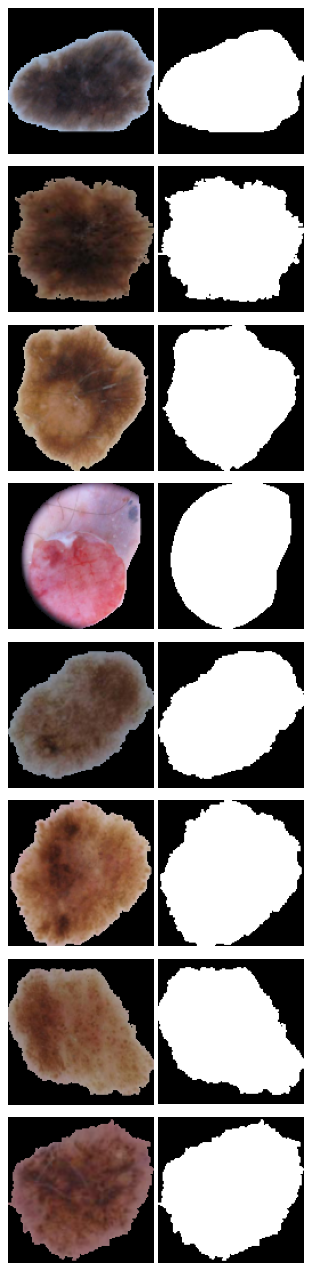

### Feature extraction

Thus, we can effectively extract the ABCD features from both the $75\%$ training subset and the $25\%$ testing subset of the data.

In [ ]:
columns = [
    "ID",
    "assymetry_index",
    "compactness",
    "fractal_dimension",
    "radial_variance",
    "correlation0",
    "correlation1",
    "correlation2",
    "homogeneity0",
    "homogeneity1",
    "homogeneity2",
    "energy0",
    "energy1",
    "energy2",
    "contrast0",
    "contrast1",
    "contrast2",
    "diameter",
]

In [ ]:
features = []
index = 0
with tqdm(train_data_loader, unit="batch") as training_epoch:
    for mask_batch, image_batch in training_epoch:
        for mask, image in zip(mask_batch, image_batch):
            contour = max(
                cv2.findContours(
                    v2.functional.to_dtype(mask, torch.uint8, scale=False)
                    .squeeze(0)
                    .numpy(),
                    mode=cv2.RETR_EXTERNAL,
                    method=cv2.CHAIN_APPROX_SIMPLE,
                )[0],
                key=cv2.contourArea,
            )

            features.append(
                [
                    train_data.basenames[index],
                    assymetry_index(mask),
                    compactness(contour),
                    fractal_dimension(mask),
                    radial_variance(center(mask), contour),
                    *correlation(image),
                    *homogeneity(image),
                    *energy(image),
                    *contrast(image),
                    diameter(contour),
                ]
            )
            index += 1

In [ ]:
features = pd.DataFrame(features, columns=columns)
features.to_csv(os.path.join(DATA_PATH, "ABCD_Features_train.csv"), index=False)

In [ ]:
features = []
index = 0
with tqdm(test_data_loader, unit="batch") as test_epoch:
    for mask_batch, image_batch in test_epoch:
        for mask, image in zip(mask_batch, image_batch):
            contour = max(
                cv2.findContours(
                    v2.functional.to_dtype(mask, torch.uint8, scale=False)
                    .squeeze(0)
                    .numpy(),
                    mode=cv2.RETR_EXTERNAL,
                    method=cv2.CHAIN_APPROX_SIMPLE,
                )[0],
                key=cv2.contourArea,
            )

            features.append(
                [
                    test_data.basenames[index],
                    assymetry_index(mask),
                    compactness(contour),
                    fractal_dimension(mask),
                    radial_variance(center(mask), contour),
                    *correlation(image),
                    *homogeneity(image),
                    *energy(image),
                    *contrast(image),
                    diameter(contour),
                ]
            )
            index +=1

In [ ]:
features = pd.DataFrame(features, columns=columns)
features.to_csv(os.path.join(DATA_PATH, "ABCD_Features_test.csv"), index=False)

## Classification: SVC

Armed with the ABCD features, models like Support Vector Classifiers (SVC) can be leveraged to effectively analyze and classify the data. Similar to previous steps, initially, only the $75\%$ of the data, originally allocated for training, is utilized for train-validation. Once optimal parameters are determined, the entire $75\%$ dataset is employed to train an SVC model. Subsequently, predictions are extracted from the remaining test dataset to evaluate the model's performance.

### Hyperparameters

In [15]:
VAL_SPLIT = 0.25

### Train-validation model

#### Data import

In [16]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "ABCD_Features_train.csv"))

metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_train["CLASS"] -= 1

In [17]:
train_data["CLASS"] = [metadata_train["CLASS"][metadata_train["ID"] == index].item() for index in train_data["ID"]]

In [18]:
X_train = train_data[
    train_data.columns[np.logical_not(train_data.columns.isin(["ID", "CLASS"]))]
].to_numpy()

y_train = train_data["CLASS"].to_numpy()

To account for class imbalance, we employ the parameter `stratify`.

In [ ]:
print("[INFO] generating the train/validation split...")

train_indices, val_indices = train_test_split(
    range(len(train_data)),
    test_size=VAL_SPLIT,
    stratify=train_data["CLASS"],
    random_state=RANDOM_SEED,
)

X_val = X_train[val_indices]
X_train = X_train[train_indices]

y_val = y_train[val_indices]
y_train = y_train[train_indices]

In [20]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

#### Data visualization

In [21]:
train_data.head()

,ID,assymetry_index,compactness,fractal_dimension,radial_variance,correlation0,correlation1,correlation2,homogeneity0,homogeneity1,homogeneity2,energy0,energy1,energy2,contrast0,contrast1,contrast2,diameter,CLASS
0,ISIC_0000000,0.547445,1.352761,0.549410,60.468847,67606.550283,86640.008216,76796.513860,171.833877,155.943593,168.431916,1231.5376,1138.3203,1351.3438,6.527195e+06,6.255227e+06,6.787778e+06,131.734582,1
1,ISIC_0000001,0.844820,2.064985,0.541871,15.839119,46887.854130,107281.200781,166021.490184,187.563042,125.479697,99.177232,1245.7400,643.7407,419.0551,6.998795e+06,5.109172e+06,4.112580e+06,131.137333,1
2,ISIC_0000003,0.795609,1.437150,0.540426,18.725808,5623.955830,27689.936389,68186.305334,340.632581,236.233317,172.043584,3282.6353,1844.5746,1115.9153,1.112062e+07,8.495908e+06,6.612566e+06,128.132744,1
3,ISIC_0000004,0.682601,1.200847,0.541107,50.749735,-986.992341,5241.058039,79.066456,485.027383,313.084887,370.166905,5629.5020,2718.9575,3935.2766,1.426461e+07,1.052223e+07,1.309992e+07,132.883408,0
4,ISIC_0000007,0.575116,1.489083,0.542179,74.295322,18480.922212,39940.564828,54687.908705,225.057388,184.288232,168.994203,1699.1987,1257.4379,1151.0403,9.928247e+06,8.712073e+06,8.313164e+06,137.360839,1


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18998 entries, 0 to 18997
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 18998 non-null  object 
 1   assymetry_index    18998 non-null  float64
 2   compactness        18998 non-null  float64
 3   fractal_dimension  18998 non-null  float64
 4   radial_variance    18998 non-null  float64
 5   correlation0       18406 non-null  float64
 6   correlation1       18407 non-null  float64
 7   correlation2       18407 non-null  float64
 8   homogeneity0       18998 non-null  float64
 9   homogeneity1       18998 non-null  float64
 10  homogeneity2       18998 non-null  float64
 11  energy0            18998 non-null  float64
 12  energy1            18998 non-null  float64
 13  energy2            18998 non-null  float64
 14  contrast0          18998 non-null  float64
 15  contrast1          18998 non-null  float64
 16  contrast2          189

In [23]:
train_data.describe()

,assymetry_index,compactness,fractal_dimension,radial_variance,correlation0,correlation1,correlation2,homogeneity0,homogeneity1,homogeneity2,energy0,energy1,energy2,contrast0,contrast1,contrast2,diameter,CLASS
count,18998.000000,18998.000000,18998.000000,18998.000000,1.840600e+04,1.840700e+04,1.840700e+04,18998.000000,18998.000000,18998.000000,18998.000000,18998.000000,18998.000000,1.899800e+04,1.899800e+04,1.899800e+04,18998.000000,18998.000000
mean,0.637925,1.564255,0.536077,94.730593,9.073471e+05,8.081774e+05,8.288411e+05,419.075664,328.066775,326.746079,4935.560666,3177.061032,3226.422392,1.380174e+07,1.097348e+07,1.097273e+07,139.496203,1.568323
std,0.216148,0.506734,0.019342,98.149516,1.065731e+07,7.898835e+06,7.923970e+06,204.890213,168.818497,174.703144,2911.785955,2114.904872,2237.419166,8.454891e+06,6.895679e+06,7.065782e+06,19.369095,1.532728
min,0.000000,1.093288,0.500000,0.250002,-1.613183e+05,-8.434119e+04,-7.463003e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,24.207437,0.000000
25%,0.507235,1.284053,0.523796,25.967978,5.997394e+02,1.492898e+03,1.115680e+03,306.551490,228.782450,209.860678,2896.558775,1707.690875,1467.766575,7.902669e+06,6.146107e+06,5.764086e+06,131.867358,1.000000
50%,0.667330,1.405982,0.534483,59.437170,4.890983e+03,8.363816e+03,8.074724e+03,455.078567,345.962389,345.989110,4998.968650,2999.369200,3081.811500,1.354867e+07,1.073798e+07,1.063361e+07,139.118654,1.000000
75%,0.797546,1.614699,0.545994,126.987715,1.901700e+04,2.820391e+04,3.436773e+04,567.489303,441.690063,451.030431,7077.650500,4384.707900,4657.493625,1.949743e+07,1.526105e+07,1.564536e+07,149.026004,2.000000
max,1.000000,17.200059,0.720639,717.480903,9.544110e+08,3.592351e+08,3.592351e+08,1006.322176,902.855299,900.681889,16005.949000,14597.266000,14580.145000,4.418530e+07,3.985393e+07,4.124118e+07,179.605122,7.000000


#### Model instantiation

The parameters `class_weight="balanced"` and `scoring="balanced accuracy"` are employed in order to account for class imbalance.

In [ ]:
svc = make_pipeline(StandardScaler(), PCA(), SVC(kernel="rbf", class_weight="balanced"))
param_grid_svc = {
    "svc__C": [1e-3, 1e-2, 1e-1, 1, 2, 5],
    "svc__gamma": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
}
grid_svc = GridSearchCV(
    svc, param_grid_svc, cv=5, scoring="balanced_accuracy", return_train_score=True
)

#### Model training

In [ ]:
grid_svc.fit(X_train, y_train)

In [ ]:
print("Best training Score: {}".format(grid_svc.best_score_))
print("Best training params: {}".format(grid_svc.best_params_))

```
Best training Score: 0.2789170075506052
Best training params: {'svc__C': 2, 'svc__gamma': 0.1}
```

Despite extensive exploration, including additional parameters such as a linear kernel and the oversampler ADASYN (omitted from this report for brevity), the highest achieved performance with our pipeline remains suboptimal, resulting in a weighted accuracy of $27\%$.

#### Model evaluation

In [ ]:
y_pred = grid_svc.predict(X_val)

In [ ]:
cnf_matrix = confusion_matrix(y_val, y_pred)

# Plot normalized confusion matrix
plt.figure()
disp = ConfusionMatrixDisplay(
    cnf_matrix
)

disp.plot(cmap="RdYlGn")

plt.show()

![CF SVC.png](<attachment:CF SVC.png>)
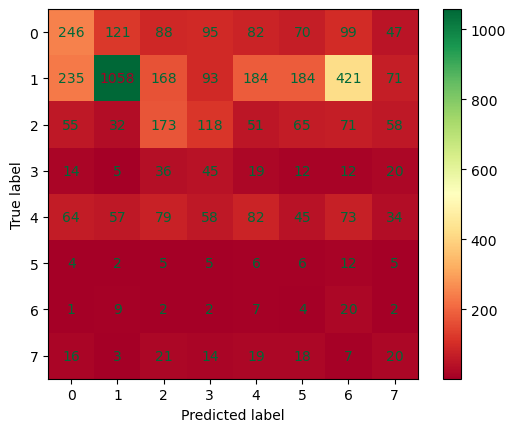

As anticipated given the low weighted accuracy value, the confusion matrix of the model on the validation data reveals a significant number of incorrect predictions. Particularly noteworthy is the model's ability to accurately identify the class "Melanocytic nevus," rarely misclassifying it, even on unseen data. This observation aligns with expectations, as this class was more prevalent in the dataset, allowing the model to better learn the underlying class boundaries for this type of lesion. However, for other classes that were less represented in the training dataset, the model struggles to discern clear boundaries, resulting in less reliable predictions.

### Train-test model

Nonetheless, the parameters of the model are still utilized to extract predictions on the test set for evaluation on Kaggle.

#### Data import

In [ ]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "ABCD_Features_train.csv"))
test_data = pd.read_csv(os.path.join(DATA_PATH, "ABCD_Features_test.csv"))

metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_train["CLASS"] -= 1

metadata_test = pd.read_csv(os.path.join(DATA_PATH, "metadataTest.csv"))

In [ ]:
train_data["CLASS"] = [metadata_train["CLASS"][metadata_train["ID"] == index].item() for index in train_data["ID"]]

In [ ]:
X_train = train_data[
    train_data.columns[np.logical_not(train_data.columns.isin(["ID", "CLASS"]))]
]

y_train = train_data["CLASS"]

X_test = test_data[
    test_data.columns[np.logical_not(test_data.columns.isin(["ID", "CLASS"]))]
]

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

#### Model instantiation

In [ ]:
svc = make_pipeline(
    StandardScaler(),
    PCA(),
    SVC(
        C=grid_svc.best_params_["svc__C"],
        gamma=grid_svc.best_params_["svc__gamma"],
        kernel="rbf",
        class_weight="balanced",
    ),
)

#### Model training

In [ ]:
svc.fit(X_train, y_train)

#### Model evaluation

In [ ]:
print("Training Score: {}".format(svc.score(X_train, y_train)))

After training with the previous parameters on the entirety of the training set, the model is able to enhance its performance, achieving a more reasonable score of approximately $38\%$.

#### Model persistence

In [ ]:
y_pred = svc.predict(X_test)
y_pred += 1

In [ ]:
metadata_test["CLASS"] = y_pred

In [ ]:
metadata_test[["ID", "CLASS"]].to_csv("Submission_SVC.csv", index=False)

In [ ]:
dump(svc, "svc.joblib")

## Classification: LeNet

In this section, the LeNet [3] architecture is employed for classification tasks within the present academic study.

LeNet is one of the pioneering convolutional neural network (CNN) architectures, originally designed for handwritten digit recognition tasks. LeNet's versatile, albeit simple, architecture makes it applicable to various image classification tasks.

LeNet consists of a series of convolutional and pooling layers followed by fully connected layers. The architecture includes alternating convolutional and pooling layers in the initial stages for feature extraction, followed by fully connected layers for classification. LeNet utilizes activation functions function to introduce non-linearity and improve model expressiveness.

In summary, LeNet offers versatility and adaptability for various image processing tasks, and can, thus, be used for classification of skin lesion images. Leveraging LeNet in our study allows us to explore its effectiveness and applicability in the context of medical image classification.

### Hyperparameters

As with the U-Net model, the consideration is limited to the Hue and Saturation (HS) channels while omitting the Value (V) component. To address potential inaccuracies in the U-Net model and to include the surrounding skin area around the lesion (albeit with lesser weight), Gaussian filtering is applied as a preprocessing step on the extracted masks. This preprocessing step aims to smoothen the mask boundaries, thereby mitigating noise and enhancing the model's ability to capture relevant features.

In [ ]:
NUM_C_CHANNELS = 2
C_SPACE = "HSV"
DISK_SIZE = 7
GAUSSIAN_KERNEL = 29
GAUSSIAN_SIGMA = 1e3
INPUT_SHAPE = 56 # Originally 28

VAL_SPLIT = 0.25

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
MAX_EPOCHS = 50

### Model definition

The `LeNet` model is deployed as follows:

In [ ]:
class LeNet(Module):
    """
    LeNet convolutional neural network architecture.

    Args:
        num_c_channels (int): Number of input color channels.
        num_classes (int): Number of output classes.
    """

    def __init__(self, num_c_channels, num_classes, input_shape):
        super(LeNet, self).__init__()

        conv1_out_channels = 6
        conv1_kernel_size = 5
        maxpool1_kernel_size = 2
        maxpool1_stride = 2

        conv2_out_channels = 16
        conv2_kernel_size = 5
        maxpool2_kernel_size = 2
        maxpool2_stride = 2

        fc1_out_features = 168 # Originally 84

        conv1_output_shape = input_shape - (conv1_kernel_size - 1)
        maxpool1_output_shape = (
            conv1_output_shape - (maxpool1_kernel_size - 1) - 1
        ) // 2 + 1

        conv2_output_shape = maxpool1_output_shape - (conv2_kernel_size - 1)
        maxpool2_output_shape = (
            conv2_output_shape - (maxpool2_kernel_size - 1) - 1
        ) // 2 + 1

        self.conv1 = Conv2d(
            in_channels=num_c_channels,
            out_channels=conv1_out_channels,
            kernel_size=conv1_kernel_size,
        )
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(
            kernel_size=maxpool1_kernel_size, stride=maxpool1_stride
        )

        self.conv2 = Conv2d(
            in_channels=conv1_out_channels,
            out_channels=conv2_out_channels,
            kernel_size=conv2_kernel_size,
        )
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(
            kernel_size=maxpool2_kernel_size, stride=maxpool2_stride
        )

        self.fc1 = Linear(
            in_features=conv2_out_channels * (maxpool2_output_shape**2),
            out_features=fc1_out_features,
        )
        self.relu3 = ReLU()

        self.fc2 = Linear(in_features=fc1_out_features, out_features=num_classes)
        self.logSoftmax = LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        output = self.logSoftmax(x)

        return output

### Dataset definition

The dataset utilized for this task operates by taking images located in a root directory and pairing them with corresponding Gaussian-filtered masks. Additionally, it receives metadata to infer the length of the dataset, image names, and, when available, class labels. This structured approach ensures the alignment of images with their respective masks and facilitates the organization of data for subsequent training and evaluation processes, while setting an infrastructure for the images to be read as batches.

In [ ]:
class CNNClassificationDataset(Dataset):
    """
    Dataset class for loading images and segmentation masks for CNN-based classification tasks.

    Args:
        root (str): Root directory containing images and masks.
        metadata (DataFrame): Metadata containing image IDs and corresponding labels.
        train (bool): Whether the dataset is for training or not.
        num_c_channels (int, optional): Number of color channels in the images. Default is 3.
        c_space (str, optional): Color space to convert the images to. Default is "RGB".
        gaussian_kernel (tuple): Size of the Gaussian kernel for mask blurring. Default is (29, 29).
        gaussian_sigma (float): Standard deviation for the Gaussian kernel. Default is 1e3.
        transforms (list of ``torchvision.transforms.Transform`` objects, optional):
            Optional transforms to be applied to the images.
    """

    def __init__(
        self,
        root,
        metadata,
        train,
        num_c_channels=3,
        c_space="RGB",
        disk_size=7,
        gaussian_kernel=29,
        gaussian_sigma=1e3,
        transforms=None,
    ):
        self.root = root
        self.metadata = metadata
        self.train = train
        self.num_c_channels = num_c_channels
        self.c_space = c_space
        self.disk_size = disk_size
        self.gaussian_kernel = gaussian_kernel
        self.gaussian_sigma = gaussian_sigma

        if transforms:
            self.transforms = v2.Compose(transforms)
        else:
            self.transforms = None

        self.pre_transforms = v2.Compose(
            [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
        )
        self.image_post_transforms = v2.Compose(
            [v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]
        )

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        image_filename = self.metadata["ID"][index]
        image_path = os.path.join(self.root, image_filename + ".jpg")
        image = Image.open(image_path, formats=["JPEG"]).convert(self.c_space)
        image = self.pre_transforms(image)

        mask_filename = image_filename + "_seg"
        mask_path = os.path.join(self.root, mask_filename + ".png")
        auth_mask_path = os.path.join(self.root, "auth", mask_filename + ".png")
        if os.path.exists(mask_path):
            mask = Image.open(mask_path, formats=["PNG"]).convert("L")
        else:
            mask = Image.open(auth_mask_path, formats=["PNG"]).convert("L")

        if np.any(np.nonzero(mask)):
            mask = self.pre_transforms(mask)
        else:
            mask = torch.ones(1, INPUT_SHAPE, INPUT_SHAPE)

        mask = v2.functional.gaussian_blur(
            mask, kernel_size=self.gaussian_kernel, sigma=self.gaussian_sigma
        )
        mask = Mask(mask)

        if self.transforms:
            image, mask = self.transforms(image, mask)

        image = self.image_post_transforms(image)
        image = image[: self.num_c_channels]

        if self.train:
            label = self.metadata["CLASS"][index]
            return image, mask, label

        return image, mask

### Train-validation model

#### Data import

In [ ]:
metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_train["CLASS"] -= 1

transforms = [
    v2.Resize((64, 64)),
    v2.RandomCrop((INPUT_SHAPE, INPUT_SHAPE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=180),
]

In [ ]:
train_data = CNNClassificationDataset(
    root=TRAIN_DATA_PATH,
    metadata=metadata_train,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    disk_size=DISK_SIZE,
    gaussian_kernel=GAUSSIAN_KERNEL,
    gaussian_sigma=GAUSSIAN_SIGMA,
    transforms=transforms,
)

Once again, the training dataset is divided into a train-validation fashion to facilitate parameter tuning. This strategy ensures that the test set is accessed only after optimal parameters have been determined, reducing the risk of overfitting and enabling more dependable evaluation of the model's performance. It is noteworthy that the parameter `stratify` is employed during the split of the train and validation data based on the class weights. This aids in mitigating model overfitting by ensuring a balanced distribution of classes between the training and validation subsets.

In [ ]:
print("[INFO] generating the train/validation split...")

train_indices, val_indices = train_test_split(
    range(len(train_data)),
    test_size=VAL_SPLIT,
    stratify=train_data.metadata["CLASS"],
    random_state=RANDOM_SEED,
)

val_data = Subset(train_data, val_indices)
train_data = Subset(train_data, train_indices)

In [ ]:
train_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)

val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

train_steps = len(train_data_loader.dataset) // BATCH_SIZE
val_steps = len(val_data_loader.dataset) // BATCH_SIZE

#### Data visualization

In [ ]:
data_iter = iter(train_data_loader)
images, masks, labels = next(data_iter)

for channel in range(NUM_C_CHANNELS):
    fig, axs = plt.subplots(
        int(np.sqrt(BATCH_SIZE)), int(np.sqrt(BATCH_SIZE)), figsize=(8, 8), dpi=80
    )

    fig.suptitle(f"Channel {channel}")
    for index, ax in enumerate(axs.flat):
        image = v2.functional.normalize(
            images[index],
            mean=[-0.5 / 0.5] * NUM_C_CHANNELS,
            std=[1 / 0.5] * NUM_C_CHANNELS,
        )[channel]
        image *= masks[index].squeeze(0)
        nplabels = labels.numpy()
        ax.imshow(image, cmap="gray")
        ax.set_title(nplabels[index])
        ax.axis("off")

    plt.tight_layout()
    plt.show()

![Visualization LeNet0.png](<attachment:Visualization LeNet0.png>)
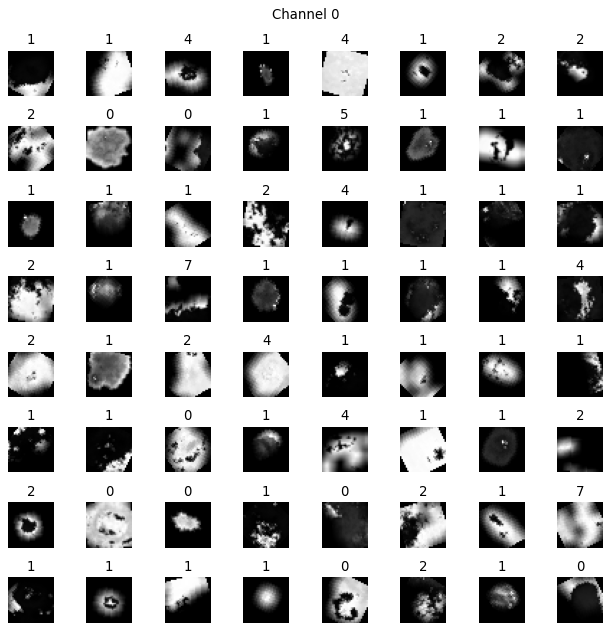

![Visualization LeNet1.png](<attachment:Visualization LeNet1.png>)
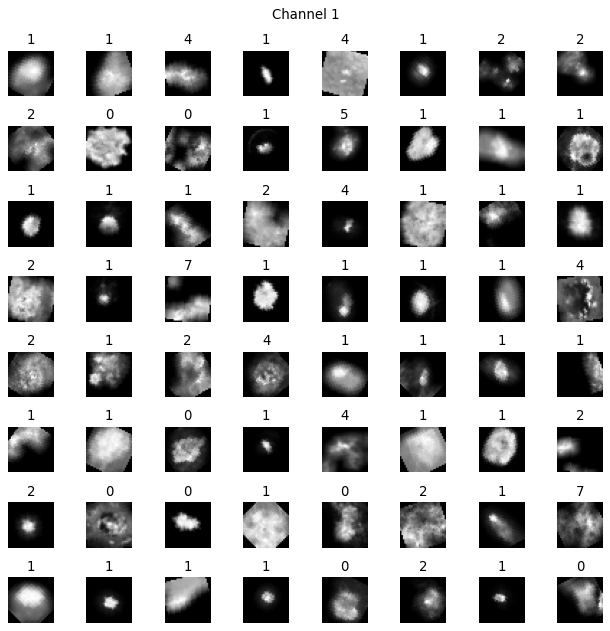

#### Model instantiation

The `Adam` optimizer and `NLLLoss` have been chosen as the optimization algorithm and loss function, respectively, with the parameter `reduction="sum"`, to mitigate potential overfitting. Additionally, the provided class weights are fixed to control model overfitting, aligning with the weighted accuracy metric used for Kaggle evaluation. This selection aims to strike a balance between model optimization and regularization, ensuring robust performance across the dataset.

In [ ]:
print("[INFO] initializing the LeNet model...")

model = LeNet(
    num_c_channels=NUM_C_CHANNELS,
    num_classes=len(CLASS_LABELS),
    input_shape=INPUT_SHAPE,
).to(DEVICE)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = NLLLoss(weight=CLASS_WEIGHTS, reduction="sum")

H = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

#### Model training

In [ ]:
print("[INFO] training the network...")

for epoch in range(0, MAX_EPOCHS):
    model.train()

    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    val_correct = 0

    with tqdm(train_data_loader, unit="batch") as training_epoch:
        for x, x_mask, y in training_epoch:
            (x, x_mask, y) = (x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE))

            x *= x_mask

            pred = model(x)

            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    with torch.no_grad(), tqdm(val_data_loader, unit="batch") as val_epoch:
        model.eval()
        for x, x_mask, y in val_epoch:
            (x, x_mask, y) = (x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE))

            x *= x_mask

            pred = model(x)

            total_val_loss += loss_function(pred, y)
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    train_correct /= len(train_data_loader.dataset)
    val_correct /= len(val_data_loader.dataset)

    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_acc"].append(train_correct)
    H["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    H["val_acc"].append(val_correct)

    print(f"[INFO] EPOCH: {epoch + 1}/{MAX_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.6f}, Train accuracy: {train_correct:.4f}")
    print(f"Val loss: {avg_val_loss:.6f}, Val accuracy: {val_correct:.4f}\n")

Following thorough training of the LeNet model to achieve a satisfactory loss value, a critical step is taken to prevent overfitting: identifying the epoch with the lowest validation loss. This epoch serves as a gauge for the optimal balance between model complexity and generalization. By pinpointing the epoch with the minimum validation loss, the model's ability to generalize to new data is confirmed, thus improving its reliability and effectiveness in real-world applications.

In [ ]:
best_epoch = np.argmin(H["val_loss"]) + 1

#### Model evaluation

In [ ]:
print("[INFO] evaluating network...")

fig, axs = plt.subplots(2, 1, figsize=(16, 10), dpi=80, sharex=True)

fig.suptitle("Train-validation model history", fontsize=24)
axs[0].set_ylabel("Loss", fontsize=22)
axs[0].plot(range(1, MAX_EPOCHS + 1), H["train_loss"], color="tab:blue", label="Train")
axs[0].plot(range(1, MAX_EPOCHS + 1), H["val_loss"], color="tab:orange", label="Test")

axs[1].set_ylabel("Accuracy", fontsize=22)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].plot(range(1, MAX_EPOCHS + 1), H["train_acc"], color="tab:blue", label="Train")
axs[1].plot(range(1, MAX_EPOCHS + 1), H["val_acc"], color="tab:orange", label="Test")

for ax in axs:
    ax.axvline(
        x=best_epoch, linestyle="--", alpha=0.6, color="tab:red", label="Best epoch"
    )
    ax.grid(axis="both", alpha=0.3)
    ax.spines[["top", "right"]].set_alpha(0.0)
    ax.spines[["bottom", "left"]].set_alpha(0.3)
    ax.legend()


plt.tight_layout()
plt.show()

![Train-validation LeNet.png](<attachment:Train-validation LeNet.png>)
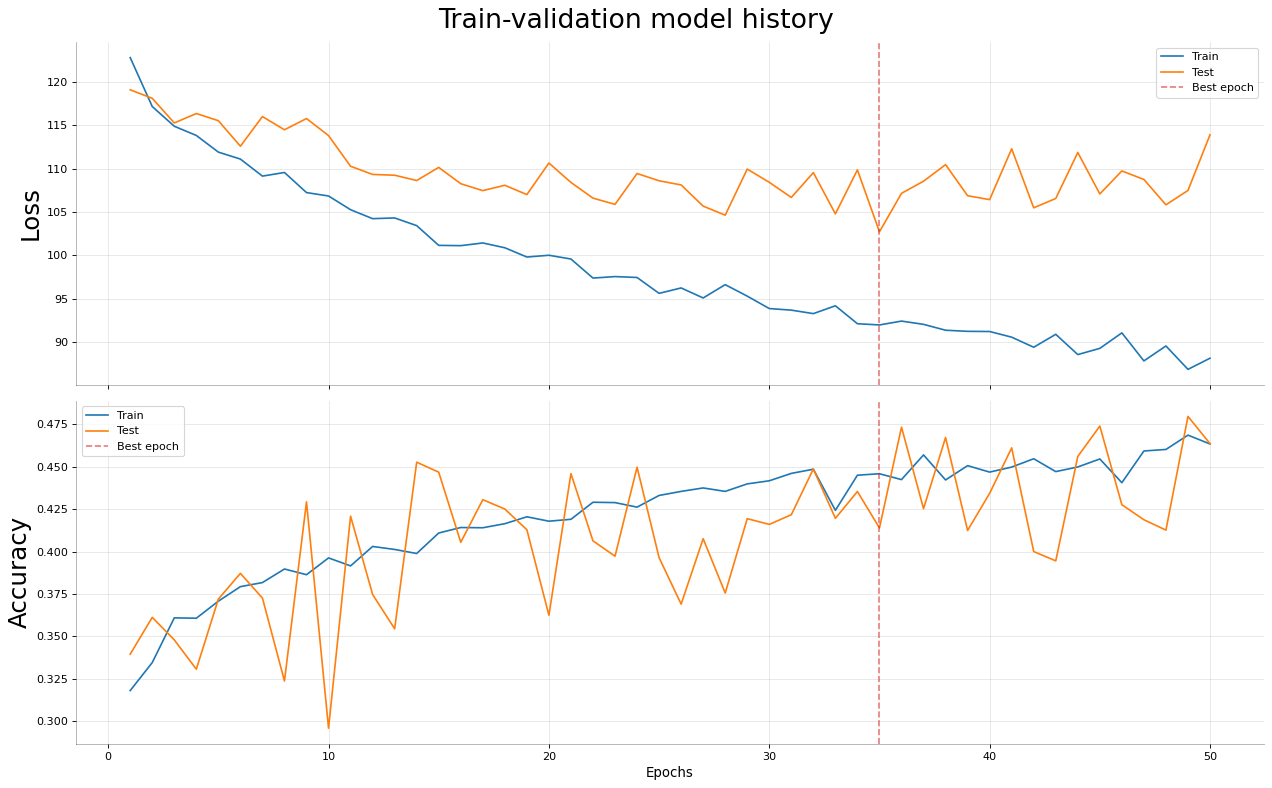

In the visualization above, overfitting becomes apparent after a certain number of epochs, as the validation loss starts to increase while the training loss continues to decrease. This highlights the significance of limiting the model's training to an optimal number of epochs, such as stopping when the validation loss reaches its minimum, to mitigate model underfitting.

In [ ]:
with torch.no_grad(), tqdm(val_data_loader, unit="batch") as val_epoch:
    model.eval()

    preds = []
    targets = []
    for x, x_mask, y in val_epoch:
        (x, x_mask, y) = (x.to(DEVICE), x_mask.to(DEVICE), y)

        x *= x_mask

        pred = model(x)

        targets.extend(y)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

print(
    classification_report(targets, np.array(preds), target_names=CLASS_LABELS.values())
)

```
               Melanoma       0.46      0.39      0.42       848
      Melanocytic nevus       0.84      0.62      0.71      2414
   Basal cell carcinoma       0.38      0.19      0.25       623
      Actinic keratosis       0.16      0.29      0.21       163
       Benign keratosis       0.24      0.26      0.25       492
         Dermatofibroma       0.06      0.40      0.10        45
        Vascular lesion       0.11      0.72      0.19        47
Squamous cell carcinoma       0.08      0.35      0.13       118

               accuracy                           0.47      4750
              macro avg       0.29      0.40      0.28      4750
           weighted avg       0.59      0.47      0.51      4750
```

### Train-test model

Here, the same pipeline employed for the train-validation model is utilized, albeit with the full $75\%$ of the provided data for training. Subsequently, the remaining $25\%$ is utilized for predictions, which are then submitted to the Kaggle challenge.

#### Data import

In [ ]:
metadata_train = pd.read_csv(os.path.join(DATA_PATH, "metadataTrain.csv"))
metadata_train["CLASS"] -= 1

metadata_test = pd.read_csv(os.path.join(DATA_PATH, "metadataTest.csv"))

transforms = [
    v2.Resize((64, 64)),
    v2.RandomCrop((INPUT_SHAPE, INPUT_SHAPE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=180),
]

In [ ]:
train_data = CNNClassificationDataset(
    root=TRAIN_DATA_PATH,
    metadata=metadata_train,
    train=True,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    disk_size=DISK_SIZE,
    gaussian_kernel=GAUSSIAN_KERNEL,
    gaussian_sigma=GAUSSIAN_SIGMA,
    transforms=transforms,
)

test_data = CNNClassificationDataset(
    root=TEST_DATA_PATH,
    metadata=metadata_test,
    train=False,
    num_c_channels=NUM_C_CHANNELS,
    c_space=C_SPACE,
    disk_size=DISK_SIZE,
    gaussian_kernel=GAUSSIAN_KERNEL,
    gaussian_sigma=GAUSSIAN_SIGMA,
    transforms=transforms,
)

In [ ]:
train_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    generator=torch.Generator().manual_seed(RANDOM_SEED),
)

train_steps = len(train_data_loader.dataset) // BATCH_SIZE

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

#### Model instantiation

In [ ]:
print("[INFO] initializing the LeNet model...")

model = LeNet(
    num_c_channels=NUM_C_CHANNELS,
    num_classes=len(CLASS_LABELS),
    input_shape=INPUT_SHAPE,
).to(DEVICE)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = NLLLoss(weight=CLASS_WEIGHTS, reduction="sum")

H = {"train_loss": [], "train_acc": []}

#### Model training

In [ ]:
print("[INFO] training the network...")

for epoch in range(0, best_epoch):
    model.train()

    total_train_loss = 0
    train_correct = 0

    with tqdm(train_data_loader, unit="batch") as training_epoch:
        for x, x_mask, y in training_epoch:
            (x, x_mask, y) = (x.to(DEVICE), x_mask.to(DEVICE), y.to(DEVICE))

            x *= x_mask

            pred = model(x)

            loss = loss_function(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss
            train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_train_loss = total_train_loss / train_steps

    train_correct /= len(train_data_loader.dataset)

    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["train_acc"].append(train_correct)

    print(f"[INFO] EPOCH: {epoch + 1}/{MAX_EPOCHS}")
    print(f"Train loss: {avg_train_loss:.6f}, Train accuracy: {train_correct:.4f}\n")

#### Model evaluation

In [ ]:
print("[INFO] evaluating network...")

fig, axs = plt.subplots(2, 1, figsize=(16, 10), dpi=80, sharex=True)

fig.suptitle("Train-test model history", fontsize=24)

axs[0].set_ylabel("Loss", fontsize=22)
axs[0].plot(range(1, best_epoch + 1), H["train_loss"], color="tab:blue")

axs[1].set_ylabel("Accuracy", fontsize=22)
axs[1].set_xlabel("Epochs", fontsize=12)
axs[1].plot(range(1, best_epoch + 1), H["train_acc"], color="tab:blue")

for ax in axs:
    ax.axvline(
        x=best_epoch, linestyle="--", alpha=0.6, color="tab:red", label="Best epoch"
    )
    ax.grid(axis="both", alpha=0.3)
    ax.spines[["top", "right"]].set_alpha(0.0)
    ax.spines[["bottom", "left"]].set_alpha(0.3)
    ax.legend()

plt.tight_layout()
plt.show()

![Train-test LeNet.png](<attachment:Train-test LeNet.png>)
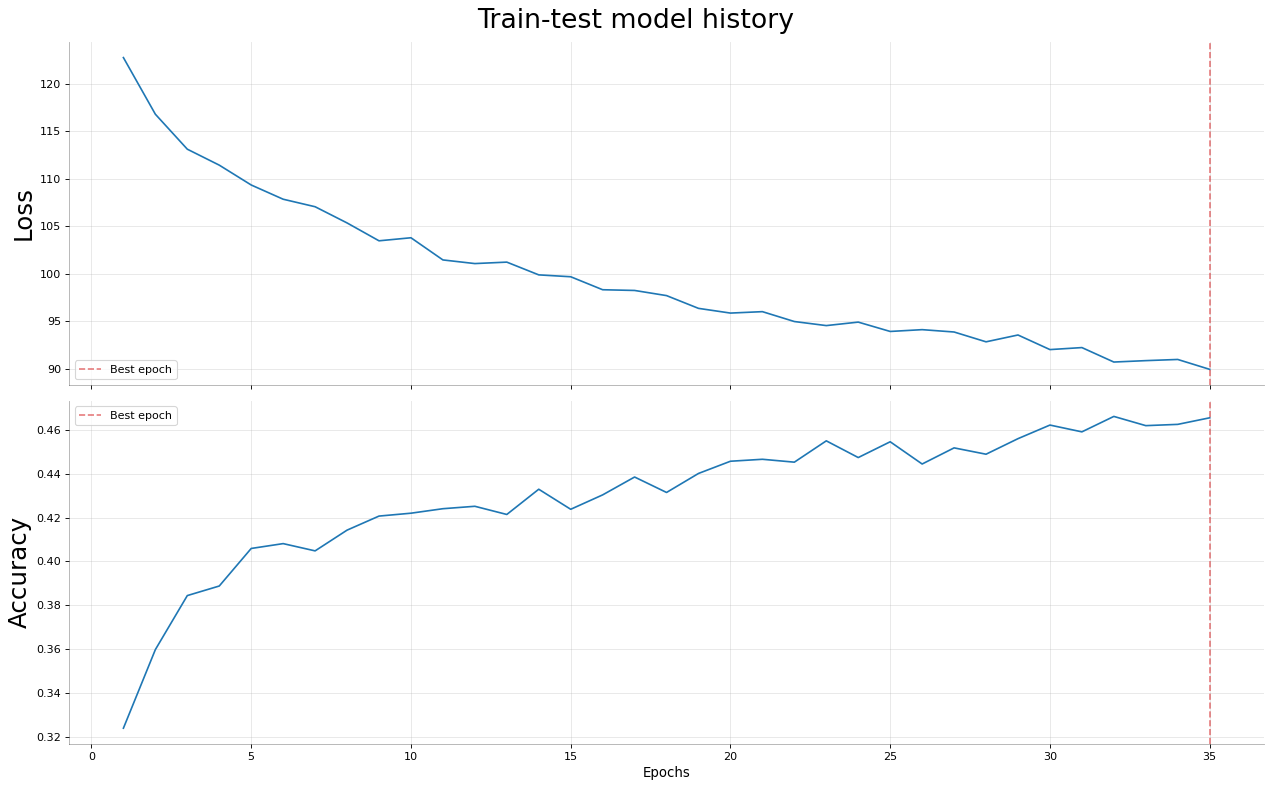

#### Model persistence

In [ ]:
with torch.no_grad(), tqdm(test_data_loader, unit="batch") as test_epoch:
    model.eval()

    preds = []
    for x, x_mask in test_epoch:
        (x, x_mask) = (x.to(DEVICE), x_mask.to(DEVICE))
        x *= x_mask
        pred = model(x)
        preds.extend(pred.argmax(axis=1).cpu().numpy())

preds = np.array(preds) + 1

In [ ]:
metadata_test["CLASS"] = preds

In [ ]:
metadata_test[["ID", "CLASS"]].to_csv("Submission_LeNet.csv", index=False)

In [ ]:
torch.save(model, "LeNet.pt")

# Results

After submitting the extracted predictions to Kaggle, the obtained results were as follows: a weighted accuracy of approximately $13\%$ with the SVC model and a weighted accuracy of approximately $50\%$ with the LeNet model.

Notably, the LeNet model outperforms the SVC in this case. This difference in performance could be attributed to the loss of important information when representing the original images with only a few ABCD features. It is conceivable that a more refined feature extraction, possibly incorporating a broader range of ABCD features or other types of features, might have enhanced the performance of the SVC model.

Even the LeNet model achieves only a modest, albeit reasonable, performance of around $50\%$. This could be attributed to the simplicity of the architecture, which may not fully capture the complexity of dermoscopic images. Originally designed for classifying handwritten digits, the LeNet model may require additional modifications, such as the inclusion of extra neurons (filters) per layers, or neural layers, or the integration of dropout or batch normalization layers, to improve its performance and generalization capability.

Yet another possibility for improvement would be to combine the outputs of both the LeNet model and the SVC model into a combined model. This could be done by adding a few neuronal layers directly to the output of the models. One could also perform the training in a cross-validation fashion in order to mitigate overfitting.

Moreover, it's essential to consider that the U-Net model was used for skin lesion segmentation and mask generation, which were utilized in both the SVM and LeNet classification models. As the U-Net model encountered difficulties in segmenting non-localized lesions, incorporating a pre-processing step of spatial normalization may enhance segmentation, consequently improving the classification models.

Finally, it's worth noting that if the GPUs from Télécom dedicated to this project were not overloaded or more readily available for student use, and with clearer guidelines on their usage to prevent abuse, it could have allowed for better fine-tuning of the employed models during training.

# Conclusion

This project outlines a comprehensive pipeline for segmenting dermoscopic images of skin lesions and classifying them into distinct categories. Leveraging well-established architectures like U-Net and LeNet, alongside canonical algorithms such as SVC, the pipeline demonstrates robustness and versatility in addressing complex image analysis tasks. The achieved performance of $50\%$ weighted accuracy on the Kaggle challenge underscores the effectiveness of the proposed methodology.

In summary, this academic endeavor represents a contribution to the field of medical image analysis. Despite the challenges encountered, the project showcases a commendable effort in leveraging techniques to tackle the segmentation and classification of skin lesions. Moving forward, there are opportunities for further refinement and enhancement, particularly in optimizing model architectures and incorporating advanced techniques for feature extraction and model training. Overall, the project's outcomes highlight the potential for continued advancements in this critical area of research.

# References

[1] Ronneberger, O., Fischer, P., & Brox, T. (2015). U-NET: Convolutional Networks for Biomedical Image Segmentation. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1505.04597

[2] Messadi, M., Cherifi, H., & Bessaid, A. (2021). Segmentation and ABCD rule extraction for skin tumors classification. arXiv (Cornell University). https://doi.org/10.48550/arxiv.2106.04372

[3] LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278–2324. https://doi.org/10.1109/5.726791